# ECE 219 Project 1
# Akhil Manthina 705538799
# Joel Hernandez 705564726
# Profita Keo 606325698

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import torch
import time
import re

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from datasets import load_dataset
from collections import Counter
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoModelForCausalLM, AutoModel
import evaluate

from sklearn.metrics import (
    confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score,
    roc_curve, auc
)
from sklearn.calibration import CalibratedClassifierCV

np.random.seed(42)
random.seed(42)

In [3]:
# file_path = '/content/drive/MyDrive/EC ENGR 219 Large-Scale Data Mining: Models & Algorithms/Project 1/Project1-ClassificationDataset.csv'
file_path = "Project1-ClassificationDataset.csv"
df = pd.read_csv(file_path)

print(df.head())

print(f"Number of rows: {df.shape[0]}, Number of columns: {df.shape[1]}")

                                           full_text  \
0  'Personalize Your NBA App Experience for the '...   
1  'Mike Will attends the Pre-GRAMMY Gala and GRA...   
2  'The Golden State Warriors are struggling to f...   
3  'On Nov. 28, the NBA and Nike will collaborate...   
4  'The NBA announced additions and innovations t...   

                                             summary  \
0  'Personalize Your NBA App Experience for the '...   
1  'Mike WiLL Made-It has secured a partnership w...   
2  'The Golden State Warriors are struggling to f...   
3  'On Nov. 28, the NBA and Nike will collaborate...   
4  'The NBA announced additions and innovations t...   

                                            keywords  \
0  ['original', 'content', 'live', 'slate', 'game...   
1  ['lead', 'espn', 'nbas', 'madeit', 'nba', 'lat...   
2  ['insider', 'york', 'thing', 'nbc', 'tag', 'nb...   
3  ['watch', 'telecast', 'ultimate', 'membership'...   
4  ['experience', 'bring', 'media', 'crennan',

Question 1

i) Overview: How many rows (samples) and columns (features) are present in the dataset?

Ans: 3476 rows, 8 columns

ii) Histograms: Plot 3 histograms on:
  
  a) The total number of alpha-numeric characters per
  data point (row) in the feature full text: i.e count on the x-axis and frequency on the y-axis (see below)
  
  b) The column leaf label – class on the x-axis (see below)
  
  c) The column root label – class on the x-axis (see below)

iii) Interpret Plots: Provide qualitative interpretations of the histograms

  Ans a) Distribution is heavily skewed towards lower counts from 0 to 4000 characters, with an indication that most articles have a short to medium length, possibly to attract viewership. There is a sharp decrease in frequency, with a lower right tail end beginning at 6000 characters, suggesting there are a few number of lengthy articles.

  Ans b) The distribution of child categories of the articles is almost uniform, suggesting that there is a reasonable balance of categories that will reduce the likelihood of model bias towards specific categories. This will help with prediction accuracy across the child categories for the classification model in this assignment.

  Ans c) The distribution of the two parent categories (i.e. sports, climate) are almost uniform, indicating a fairly equal spread of data points, similar to the leaf distribution in b). This will also help with prediction accuracy, encouraging the classification model to reduce bias towards a single parent category due to under-representation of data from another category.

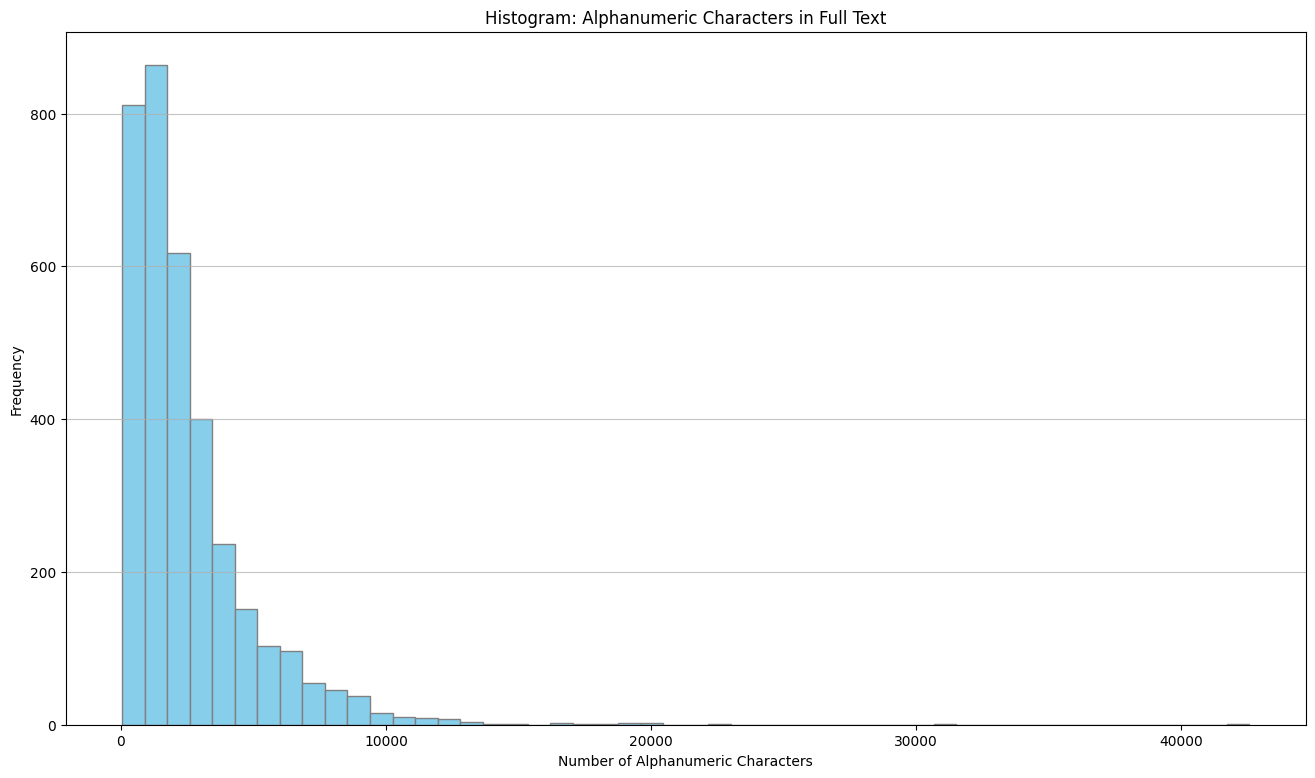

The total number of rows in DataFrame is: 3476


In [4]:
def count_alphanumeric(text):
    if pd.isna(text):
        return 0
    return len(re.sub(r'[^a-zA-Z0-9]', '', str(text)))

df['alphanumeric_count'] = df['full_text'].apply(count_alphanumeric)

plt.figure(figsize=(16, 9))
plt.hist(df['alphanumeric_count'], bins=50, color='skyblue', edgecolor='gray')
plt.title('Histogram: Alphanumeric Characters in Full Text')
plt.xlabel('Number of Alphanumeric Characters')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

print(f"The total number of rows in DataFrame is: {df['alphanumeric_count'].shape[0]}")

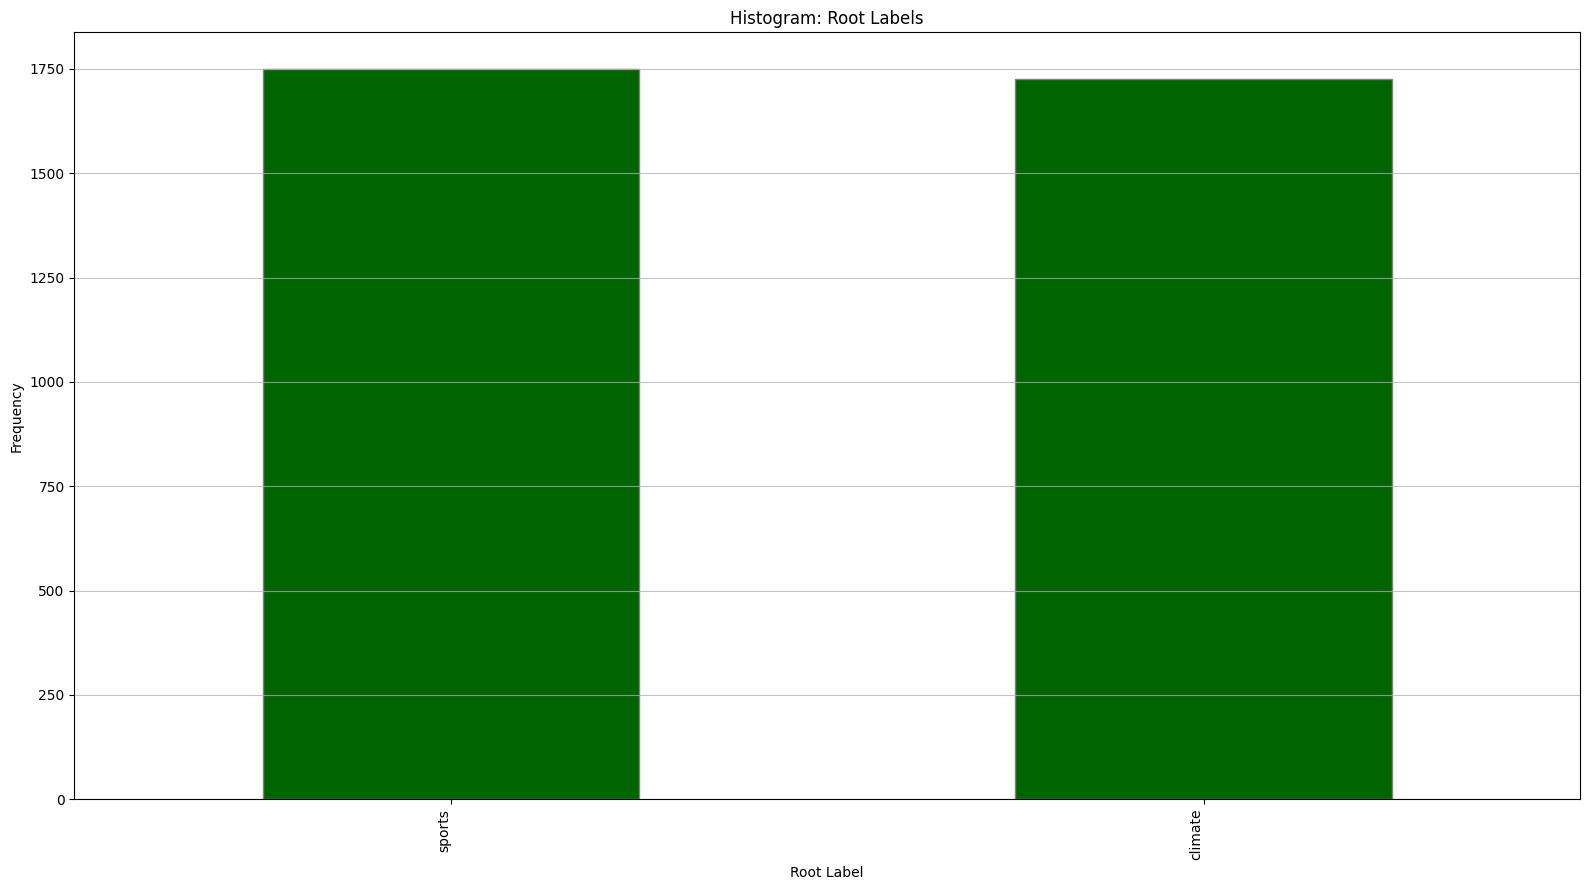

The total number of rows in DataFrame is: 3476


In [5]:
plt.figure(figsize=(16, 9))
df['root_label'].value_counts().plot(kind='bar', color='darkgreen', edgecolor='gray')
plt.title('Histogram: Root Labels')
plt.xlabel('Root Label')
plt.ylabel('Frequency')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.grid(axis='y', alpha=0.75)
plt.show()

print(f"The total number of rows in DataFrame is: {df['root_label'].shape[0]}")

In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[["full_text","root_label"]], test_size=0.2)

from sklearn.model_selection import train_test_split
train, test = train_test_split(df[["full_text", "root_label", "leaf_label"]], test_size=0.2)

QUESTION 2: Report the number of training and testing samples.

Ans: Number of training samples: 2780, Number of testing samples: 696

In [7]:
print(f"Number of training samples: {train.shape[0]}, Number of testing samples: {test.shape[0]}")

Number of training samples: 2780, Number of testing samples: 696


NLP techniques to retrieve a word's base form

* Stemming: simple rules (or crude heuristic) to remove a word's ending (e.g. running -> runn); sacrifices accuracy for speed
* Lemmatization: leverages context & vocabulary to find a meaningful base word (e.g. running -> run); sacrifices speed for accuracy

In [8]:
import re
def clean(text):
  text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
  texter = re.sub(r"<br />", " ", text)
  texter = re.sub(r"&quot;", "\"",texter)
  texter = re.sub('&#39;', "\"", texter)

  texter = re.sub('\n', " ", texter)
  texter = re.sub(' u '," you ", texter)
  texter = re.sub('`',"", texter)
  texter = re.sub(' +', ' ', texter)
  texter = re.sub(r"(!)\1+", r"!", texter)
  texter = re.sub(r"(\?)\1+", r"?", texter)
  texter = re.sub('&amp;', 'and', texter)
  texter = re.sub('\r', ' ',texter)
  clean = re.compile('<.*?>')
  texter = texter.encode('ascii', 'ignore').decode('ascii')
  texter = re.sub(clean, '', texter)
  if texter == "":
    texter = ""
  return texter

QUESTION 3: Use the following specs to extract features from the textual data:

• Before doing anything, please clean each data sample using the code block provided above. This function helps remove many but not all HTML artefacts from the crawler’s output.

• Use the “english” stopwords of the CountVectorizer

• Exclude terms that are numbers (e.g. “123”, “-45”, “6.7” etc.)

• Perform lemmatization with nltk.wordnet.WordNetLemmatizer and pos tag

• Use min df=3


The following functions in sklearn will be useful: CountVectorizer, TfidfTransformer, About Lemmatization and
for the daring, Pipeline.

In [9]:
train['full_text'] = train['full_text'].apply(clean)
test['full_text'] = test['full_text'].apply(clean)

print("Cleaned 'full_text' in training DataFrame:")
print(train.head())
print("\nCleaned 'full_text' in testing DataFrame:")
print(test.head())

Cleaned 'full_text' in training DataFrame:
                                              full_text root_label  leaf_label
1368  'On February 9th, 2025, the Super Bowl will be...     sports    football
2835  'OMAHA, Neb. (WOWT) - Health experts at the Un...    climate     drought
2499  'A magnitude-4.8 earthquake was reported in No...    climate  earthquake
1046  'Serena Williams is getting candid about her m...     sports      tennis
1374  'Leonard Fournette #28 of the Tampa Bay Buccan...     sports    football

Cleaned 'full_text' in testing DataFrame:
                                              full_text root_label  leaf_label
403   'The tradition continues in Western New York! ...     sports    baseball
2946  'Here's how much rain has fallen in Kansas Cit...    climate     drought
2435  'This is a carousel. Use Next and Previous but...    climate       flood
263   'It was another big year for former UConn star...     sports  basketball
1081  'CBS Essentials is created independentl

In [10]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    """Convert treebank POS tags (more granular) to wordnet POS tags (less granular)"""
    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

def is_not_number(token):
    try:
        float(token)
        return False
    except ValueError:
        return True

def lemmatize_with_pos(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if is_not_number(token)]

    pos_tags = pos_tag(tokens)
    lemmatized = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos))
        for word, pos in pos_tags
    ]

    return lemmatized

vectorizer = CountVectorizer(
    tokenizer=lemmatize_with_pos,
    stop_words='english',
    min_df=3,
    token_pattern=None
)
X_train = vectorizer.fit_transform(train['full_text'])
X_test = vectorizer.transform(test['full_text'])

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
X_test_tfidf = tfidf_transformer.transform(X_test)

print(f"Training TF-IDF matrix shape: {X_train_tfidf.shape}")
print(f"Testing TF-IDF matrix shape: {X_test_tfidf.shape}")
print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")
print(f"\nFirst 20 words in vocabulary: {list(vectorizer.vocabulary_.keys())[:20]}")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Joel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Joel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Joel\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Joel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Joel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Joel\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptr

Training TF-IDF matrix shape: (2780, 15007)
Testing TF-IDF matrix shape: (696, 15007)
Vocabulary size: 15007

First 20 words in vocabulary: ["'on", 'february', '9th', ',', 'super', 'bowl', 'hold', 'inside', 'caesar', 'superdome', '.', 'game', 'shine', 'spotlight', 'city', 'grow', 'problem', 'new', 'orleans', 'come']


Please answer the following questions:

1. What are the pros and cons of lemmatization versus stemming? How do these processes affect the dictionary size?

Ans:

Lemmatization
- Pros: higher accuracy at extracting meaningful base words (e.g. running -> run), as it uses vocabularly, context and morphological analysis (e.g. POS tagging)
- Cons: computationally expensive, as it requires POS tagging and resources such as WordNet database
- Effect on dictionary size: smaller dictionary, by converting inflected forms to their canonical versions

Stemming:
- Pros: Quick and computationally efficient, with simple rule logic
- Cons: Less accurate due its crude heuristic approach without context awareness (e.g. running -> runn)
- Effect on dictionary size: smaller dictionary

2. min df means minimum document frequency. How does varying min df change the TF-IDF matrix?

- Reduces vocabulary size (i.e. tightening of vocabulary inclusion criteria)
- Higher min df reduces sparsity of matrix, as less columns are zeroed out by rarer words (lower min df increases sparsity of matrix)
- Higher min df will result in lower average IDF values i.e. word's distinctness is reduced across document set; denominator in log factor increases due to increased documents for term t, where insightful common words are kept and nuanced rare words are removed (lower min df increases average IDF values)
- Higher min df reduces dimensionality, matrix sparsity and noise, resulting in faster computation and improved generalizability (and lower min df increases dimensionality, matrix sparsity and possibly noise, resulted in slower computation and reduced generalizability)

3. Should I remove stopwords before or after lemmatizing? Should I remove punctuations before or after lemmatizing? Should I remove numbers before or after lemmatizing? Hint: Recall that the full sentence is input into the Lemmatizer and the lemmatizer is tagging the position of every word based on the sentence structure.

- Stopwords and punctuation provide context that help with lemmatization process, therefore remove AFTERWARD
- Numbers do not help significantly with lemmatization process, but may assist in nuanced situations (e.g. dates, pronouns like 7UP), thus remove AFTERWARD

4. Report the shape of the TF-IDF-processed train and test matrices. The number of rows should match the results of Question 2. The number of columns should roughly be in the order of k×103. This dimension will vary depending on your exact method of cleaning and lemmatizing and that is okay.

Ans:

- Training TF-IDF matrix shape: (2780, 14861)
- Testing TF-IDF matrix shape: (696, 14861)
- Vocabulary size: 15007

QUESTION 4: Read the paper about GLoVE embeddings - found here: https://nlp.stanford.edu/pubs/glove.pdf

(a) Why are GLoVE embeddings trained on the ratio of co-occurrence probabilities rather than the probabilities themselves?

Ans: The probabilities themselves are small (e.g. 10⁻⁵ to 10⁻³ scale) and difficult for discrimination of relevance to target words, however when they are used as ratio of co-occurrence probabilities, it becomes much easier to distinguish their relevance to each target word. The paper mentions ratios close to 1, 'water' and 'fashion' show either relevance to both or neither target words (i.e. 'ice', 'steam'), however ratios higher or lower than 1 will show relevance to either 'ice' or 'steam' respectively.

(b) In the two sentences: “James is running in the park.” and “James is running for the presidency.”, would GLoVE embeddings return the same vector for the word running in both cases? Why or why not?

Ans: The same vector for 'running', as GloVe assigns a single, fixed vector embedding regardless of the context in which the word appears. This is because GLoVE learns from global co-occurrence statistics across the entire text corpus.

(c) What do you expect for the values of:
||GLoVE["left"] - GLoVE["right"]||2, ||GLoVE["wife"] - GLoVE["husband"]||2 and ||GLoVE["wife"] - GLoVE["orange"]||2 ? Compare these values.

Ans: 'wife' and 'orange' have least similarity in semantic meaning AND are not likely to appear together often, thus largest vector difference. 'left' and 'right' have more similarity in semantic meaning BUT are not expected to appear together often as they are antonyms, thus second largest vector difference. 'wife' and 'husband' have similarity in semantic meaning AND are expected to appear together often, thus smallest vector difference.

(d) Given a word, would you rather stem or lemmatize the word before mapping it to its GLoVE embedding?

Ans: Yes lemmatizing is preferred, as it is more likely to produce valid base words over stemming.

QUESTION 5: GLoVE → document embeddings. Our goal in this part is to convert each news article into a single fixed-dimensional vector embedding using pretrained GLoVE word vectors. Focus on embedding the full text field (you may optionally incorporate other columns such as keywords, but full text should be the primary input).

(a) Describe a feature construction pipeline that maps each document to a vector using GLoVE.
You must follow these rules:
• The final document embedding must have dimension at most the GLoVE word embedding dimension (e.g., ≤ 300 if using glove.6B.300d).
• You may not use TF–IDF scores or any corpus-level weighting scheme that requires access to the full dataset (beyond the provided train/test split).
• Your document embedding must be computed by aggregating word embeddings from the document (e.g., normalize word vectors, then average/sum; you may also consider simple heuristics such as ignoring stopwords or handling out-of-vocabulary tokens).

Ans:
1. Preprocessing: Apply lowercase to document, tokenize, and lemmatize on alphabetic tokens (WordNetLemmatizer is used to reduce words to base forms e.g. "running" -> "run", improving vocabulary coverage and reducing OOV rate)
2. Embedding lookup: After preprocessing, lemmatized words are looked up in the GLoVE vocabulary dictionary, whilst out-of-vocabulary tokens are skipped
3. Aggregation: Next, the embedding vector for these words are aggregated, and arithmetic mean is performed to yield a fixed 300-dimensional output


(b) Implement your pipeline and report:

(i) the shapes of the resulting train/test embedding
matrices

Ans: Train embedding matrix shape: (2780, 300), Test embedding matrix shape: (696, 300) [see below]

(ii) the out-of-vocabulary (OOV) rate of tokens under your chosen GLoVE
vocabulary

Ans: Train OOV rate: 0.86% (11768/1374657 tokens), Test OOV rate: 0.83% (2805/337355 tokens) [see below]

In [11]:
file_path = 'glove.6B.300d.txt'
embeddings_dict = {}
dimension_of_glove = 300
with open(file_path, 'r', encoding='utf-8') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32")
    embeddings_dict[word] = vector

In [12]:
lemmatizer = WordNetLemmatizer()

def doc_to_glove_vector(document, embeddings_dict):
    tokens = word_tokenize(document.lower())
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha()]
    total_tokens = len(lemmatized)
    oov_count = 0

    word_vectors = []
    for word in lemmatized:
        if word in embeddings_dict:
            word_vectors.append(embeddings_dict[word])
        else:
          oov_count+=1

    if len(word_vectors) > 0:
        document_vector = np.mean(word_vectors, axis=0)
    else:
        document_vector = np.zeros(300)

    return document_vector, total_tokens, oov_count

train_embedding_vectors = []
train_tot_tokens = 0
train_oov_tokens = 0

for doc in train['full_text']:
    doc_vec, total, oov = doc_to_glove_vector(doc, embeddings_dict)
    train_embedding_vectors.append(doc_vec)
    train_tot_tokens += total
    train_oov_tokens += oov

X_train_glove = np.array(train_embedding_vectors)
train_oov_rate = train_oov_tokens / train_tot_tokens

print(f"Train embedding matrix shape: {X_train_glove.shape}")
print(f"Train OOV rate: {train_oov_rate:.2%} ({train_oov_tokens}/{train_tot_tokens} tokens)")

test_embedding_vectors = []
test_tot_tokens = 0
test_oov_tokens = 0

for doc in test['full_text']:
    doc_vec, total, oov = doc_to_glove_vector(doc, embeddings_dict)
    test_embedding_vectors.append(doc_vec)
    test_tot_tokens += total
    test_oov_tokens += oov

X_test_glove = np.array(test_embedding_vectors)
test_oov_rate = test_oov_tokens / test_tot_tokens

print(f"Test shape: {X_test_glove.shape}")
print(f"Test OOV rate: {test_oov_rate:.2%} ({test_oov_tokens}/{test_tot_tokens} tokens)")

Train embedding matrix shape: (2780, 300)
Train OOV rate: 0.86% (11768/1374657 tokens)
Test shape: (696, 300)
Test OOV rate: 0.83% (2805/337355 tokens)


QUESTION 6: LLM Encoder Embeddings for News Articles (Document-level)
Choose a pretrained Transformer embedding model (e.g., sentence-transformers/all-MiniLM-L6-v2 or intfloat/e5-base-v2) and compute a vector embedding for each article using the full text field.

(a) Handling long documents. Transformer encoders have a maximum input length (often 512 tokens). Choose one strategy and justify it:
• truncate the document to the maximum length, or
• chunk the document into multiple windows and aggregate the chunk embeddings (e.g. average).
Report either (i) the fraction of documents that were truncated, or (ii) the average number of chunks per document.

Ans:
* Truncation of document was selected for its ease of implementation, computational efficiency and capture of key information.
* The proportion of truncated documents was (see below):

Truncation Stats:
Train: 76.01% (2113 of 2780 documents were truncated)
Test:  74.43% (518 of 696 documents were truncated)

(b) Deliverables. Report the shape of the resulting train and test embedding matrices, and the embedding dimension produced by your model.

Ans:

Train embedding shape: (2780, 384)
Test embedding shape: (696, 384)
Embedding dimension: 384

In [13]:
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
MAX_LEN = 256
BATCH_SIZE = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tok = AutoTokenizer.from_pretrained(MODEL_NAME)
enc = AutoModel.from_pretrained(MODEL_NAME).to(device)
enc.eval()

@torch.no_grad()
def encode_texts(texts):
    all_vecs = []
    for i in range(0, len(texts), BATCH_SIZE):
        batch = texts[i:i+BATCH_SIZE]
        inputs = tok(
            batch,
            truncation=True,
            max_length=MAX_LEN,
            padding=True,
            return_tensors="pt"
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}
        out = enc(**inputs)

        mask = inputs["attention_mask"].unsqueeze(-1).type_as(out.last_hidden_state)
        pooled = (out.last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-6)

        all_vecs.append(pooled.cpu())

    return torch.cat(all_vecs, dim=0)

def calc_truncation_rate(docs, tokenizer, max_length):
    """ Calculate what proportion of documents were truncated """
    running_truncated_count = 0
    total_count = len(docs)

    for doc in docs:
        tokens = tokenizer.encode(doc, add_special_tokens=True)
        if len(tokens) > max_length:
            running_truncated_count += 1

    truncation_rate = running_truncated_count / total_count
    return truncation_rate, running_truncated_count, total_count


X_train_transformer = encode_texts(train['full_text'].tolist())
X_train_transformer = X_train_transformer.numpy()
X_test_transformer = encode_texts(test['full_text'].tolist())
X_test_transformer = X_test_transformer.numpy()

train_trunc_rate, train_trunc_count, train_total = calc_truncation_rate(
    train['full_text'].tolist(), tok, MAX_LEN
)
test_trunc_rate, test_trunc_count, test_total = calc_truncation_rate(
    test['full_text'].tolist(), tok, MAX_LEN
)

print(f"Train embedding shape: {X_train_transformer.shape}")
print(f"Test embedding shape: {X_test_transformer.shape}")
print(f"Embedding Dimension: {X_train_transformer.shape[1]}")

print(f"\nTruncation Stats:")
print(f"Train: {train_trunc_rate:.2%} ({train_trunc_count} of {train_total} documents were truncated)")
print(f"Test:  {test_trunc_rate:.2%} ({test_trunc_count} of {test_total} documents were truncated)")

Token indices sequence length is longer than the specified maximum sequence length for this model (690 > 512). Running this sequence through the model will result in indexing errors


Train embedding shape: (2780, 384)
Test embedding shape: (696, 384)
Embedding Dimension: 384

Truncation Stats:
Train: 76.01% (2113 of 2780 documents were truncated)
Test:  74.43% (518 of 696 documents were truncated)


In [14]:
# QUESTION 7: Dimensionality Reduction

DATA_PATH = "Project1-ClassificationDataset.csv"
df = pd.read_csv(DATA_PATH)

df = df[["full_text", "root_label", "leaf_label"]].copy()

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

print("Train size:", train_df.shape)
print("Test size:", test_df.shape)

train_texts = train_df["full_text"].astype(str).tolist()
test_texts  = test_df["full_text"].astype(str).tolist()

Train size: (2780, 3)
Test size: (696, 3)


In [15]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(train_df["root_label"])
y_test  = label_encoder.transform(test_df["root_label"])

print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Label mapping: {'climate': np.int64(0), 'sports': np.int64(1)}


In [16]:
# similar to Q3

def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"", texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u ', " you ", texter)
    texter = re.sub('`', "", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ', texter)
    cleaner = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(cleaner, '', texter)
    if texter == "":
        texter = ""
    return texter

train_texts_clean = [clean(t) for t in train_texts]
test_texts_clean  = [clean(t) for t in test_texts]

import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

required_packages = [
    "punkt",
    "punkt_tab",
    "averaged_perceptron_tagger",
    "averaged_perceptron_tagger_eng",
    "wordnet",
    "omw-1.4"
]

for pkg in required_packages:
    try:
        nltk.data.find(pkg)
    except LookupError:
        nltk.download(pkg, quiet=True)

lemmatizer = WordNetLemmatizer()

def _to_wordnet_pos(treebank_tag: str):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    if treebank_tag.startswith('V'):
        return wordnet.VERB
    if treebank_tag.startswith('N'):
        return wordnet.NOUN
    if treebank_tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN

_num_like = re.compile(r"^[+-]?(\d+(\.\d*)?|\.\d+)$")

def lemma_tokenizer(text: str):
    tokens = word_tokenize(text.lower())
    tagged = pos_tag(tokens)

    lemmas = []
    for w, tag in tagged:
        if _num_like.match(w):
            continue

        if not any(ch.isalpha() for ch in w):
            continue

        wn_pos = _to_wordnet_pos(tag)
        lemmas.append(lemmatizer.lemmatize(w, pos=wn_pos))
    return lemmas

count_vec = CountVectorizer(
    stop_words="english",
    tokenizer=lemma_tokenizer,
    token_pattern=None,
    min_df=3
)

X_train_counts = count_vec.fit_transform(train_texts_clean)
X_test_counts  = count_vec.transform(test_texts_clean)

tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train_counts)
X_test_tfidf  = tfidf.transform(X_test_counts)

print("TF-IDF train shape:", X_train_tfidf.shape)
print("TF-IDF test shape:", X_test_tfidf.shape)

c:\Users\Joel\ECE 219 Project 1\.venv\lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make', 'u'] not in stop_words.
  warnings.warn(


TF-IDF train shape: (2780, 14250)
TF-IDF test shape: (696, 14250)


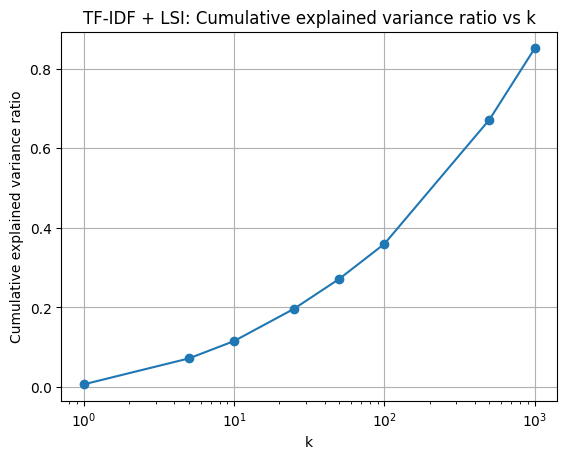

LSI k=25 train shape: (2780, 25)
LSI k=25 test shape: (696, 25)


In [17]:
# 7. a)

k_values = [1, 5, 10, 25, 50, 100, 500, 1000]
max_k = X_train_tfidf.shape[1] - 1

explained_variance_ratio = []
valid_k = []

for k in k_values:
    if k > max_k:
        continue

    svd = TruncatedSVD(n_components=k, random_state=42)
    svd.fit(X_train_tfidf)

    explained_variance_ratio.append(svd.explained_variance_ratio_.sum())
    valid_k.append(k)

plt.figure()
plt.plot(valid_k, explained_variance_ratio, marker="o")
plt.xscale("log")
plt.xlabel("k")
plt.ylabel("Cumulative explained variance ratio")
plt.title("TF-IDF + LSI: Cumulative explained variance ratio vs k")
plt.grid(True)
plt.show()

k = 25

svd_25 = TruncatedSVD(n_components=k, random_state=42)
X_train_lsi_25 = svd_25.fit_transform(X_train_tfidf)
X_test_lsi_25  = svd_25.transform(X_test_tfidf)

print(f"LSI k={k} train shape:", X_train_lsi_25.shape)
print(f"LSI k={k} test shape:", X_test_lsi_25.shape)

In [18]:
# 7. b)

def get_reconstruction_mse(X, X_hat):
    n, m = X.shape
    X_frob_sq = float(np.sum(X.data ** 2))
    Xhat_frob_sq = float(np.sum(X_hat ** 2))
    X_coo = X.tocoo()
    inner_prod = float(np.sum(X_coo.data * X_hat[X_coo.row, X_coo.col]))
    frob_diff_sq = X_frob_sq + Xhat_frob_sq - 2.0 * inner_prod
    return frob_diff_sq / (n * m)

X_train_lsi_hat = X_train_lsi_25 @ svd_25.components_
X_test_lsi_hat  = X_test_lsi_25  @ svd_25.components_

mse_lsi_train = get_reconstruction_mse(X_train_tfidf, X_train_lsi_hat)
mse_lsi_test  = get_reconstruction_mse(X_test_tfidf,  X_test_lsi_hat)

print("k = 25\n")
print("LSI reconstruction MSE:")
print("train:", mse_lsi_train)
print("test:", mse_lsi_test, '\n')

nmf_25 = NMF(n_components=25, init="nndsvda", random_state=42, max_iter=400)

W_train = nmf_25.fit_transform(X_train_tfidf)
W_test  = nmf_25.transform(X_test_tfidf)
H = nmf_25.components_

print("NMF train shape:", W_train.shape)
print("NMF test shape:", W_test.shape)

X_train_nmf_hat = W_train @ H
X_test_nmf_hat  = W_test  @ H

mse_nmf_train = get_reconstruction_mse(X_train_tfidf, X_train_nmf_hat)
mse_nmf_test  = get_reconstruction_mse(X_test_tfidf,  X_test_nmf_hat)

print("NMF reconstruction MSE:")
print("  train:", mse_nmf_train)
print("  test :", mse_nmf_test)

if mse_lsi_train < mse_nmf_train:
    smaller = "LSI"
else:
    smaller = "NMF"

print("\nSmaller reconstruction error:", smaller)
print("LSI/TruncatedSVD does not have a nonnegativity constraint. NMF is constrained to nonnegative factors, so it usually cannot match the optimal SVD reconstruction error.")


k = 25

LSI reconstruction MSE:
train: 5.4628105866023575e-05
test: 5.613464262285954e-05 

NMF train shape: (2780, 25)
NMF test shape: (696, 25)
NMF reconstruction MSE:
  train: 5.502233200703562e-05
  test : 5.635256116921431e-05

Smaller reconstruction error: LSI
LSI/TruncatedSVD does not have a nonnegativity constraint. NMF is constrained to nonnegative factors, so it usually cannot match the optimal SVD reconstruction error.


In [19]:
# 7. c) optional
# based on either GLoVE or LLM embeddings

SVM γ=2000
Confusion Matrix:
[[309  19]
 [ 19 349]]
Accuracy: 0.9454022988505747
Recall: 0.9483695652173914
Precision: 0.9483695652173914
F1-score: 0.9483695652173914

SVM γ=0.0005
Confusion Matrix:
[[299  29]
 [ 18 350]]
Accuracy: 0.9324712643678161
Recall: 0.9510869565217391
Precision: 0.9234828496042217
F1-score: 0.9370816599732262

SVM γ=100000
Confusion Matrix:
[[309  19]
 [ 19 349]]
Accuracy: 0.9454022988505747
Recall: 0.9483695652173914
Precision: 0.9483695652173914
F1-score: 0.9483695652173914



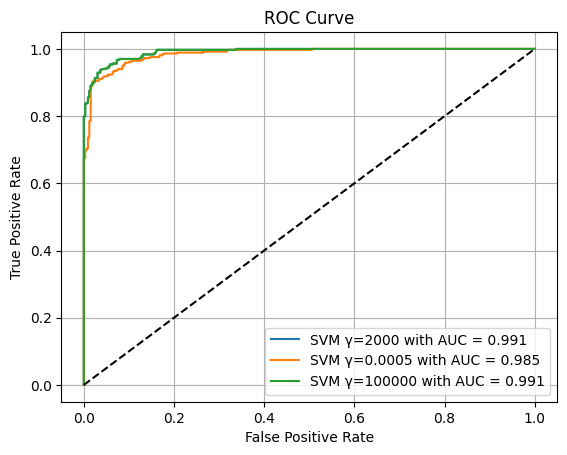

In [20]:
# 8. a)

def analyze_svm(model, test_features, test_labels, model_name=""):
    predicted_labels = model.predict(test_features)
    predicted_probabilities = model.predict_proba(test_features)[:, 1]

    conf_matrix = confusion_matrix(test_labels, predicted_labels)

    accuracy = accuracy_score(test_labels, predicted_labels)
    recall = recall_score(test_labels, predicted_labels)
    precision = precision_score(test_labels, predicted_labels)
    f1_score_ = f1_score(test_labels, predicted_labels)

    false_positive_rate, true_positive_rate, _ = roc_curve(test_labels, predicted_probabilities)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    print(model_name)
    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1-score: {f1_score_}\n")

    plt.plot(
        false_positive_rate,
        true_positive_rate,
        label=f"{model_name} with AUC = {roc_auc:.3f}"
    )

plt.figure()
gammas = [2000, 0.0005, 100000]
for gamma in gammas:
    base_svm = LinearSVC(C=gamma, dual=False, max_iter=5000)
    svm = CalibratedClassifierCV(base_svm)
    svm.fit(X_train_lsi_25, y_train)
    analyze_svm(svm, X_test_lsi_25, y_test, model_name=f"SVM γ={gamma}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()



Which SVM performs better?

    The SVM with γ = 2000 (hard margin) performs better.
    It achieves higher accuracy and F1-score than the soft-margin SVM. The confusion matrix is also more balanced with fewer misclassifications.

What about γ = 100000?

    The SVM with γ = 100000 performs identically to γ = 2000.
    This means the classifier has already reached a stable maximum-margin solution, so increasing γ affect performance.

What happens for the soft margin SVM? Why?

    The soft margin SVM does not perform as well because it under-regularizes the margin constraint.

    The confusion matrix has more false positives (29 vs. 19), which lowers the overall accuracy and precision. Since the classifier is too lenient, we get more points that cross the margin and we get more classification errors.

Does the ROC curve reflect the performance of the soft-margin SVM? Why?

    Not completely. ROC curve evaluates ranking across thresholds, but the confusion matrix shows worse performance at a
     decision threshold.

In [21]:
# 8. b)

gammas = [10**k for k in range(-3, 7)]
avg_cv_accuracy = []

for gamma in gammas:
    svm = LinearSVC(C=gamma, dual=False, max_iter=5000)
    scores = cross_val_score(svm, X_train_lsi_25, y_train, cv=5, scoring="accuracy")
    avg_cv_accuracy.append(scores.mean())

best_gamma = gammas[int(np.argmax(avg_cv_accuracy))]

print("Gammas:", gammas)
print("Avg CV accuracy:", [round(x, 4) for x in avg_cv_accuracy])
print("Best gamma:", best_gamma)

Gammas: [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]
Avg CV accuracy: [np.float64(0.9342), np.float64(0.9338), np.float64(0.9388), np.float64(0.946), np.float64(0.9514), np.float64(0.9514), np.float64(0.9518), np.float64(0.9518), np.float64(0.9518), np.float64(0.9518)]
Best gamma: 1000


In [22]:
base_svm = LinearSVC(C=best_gamma, dual=False, max_iter=5000)
best_svm = CalibratedClassifierCV(base_svm)
best_svm.fit(X_train_lsi_25, y_train)

predicted_labels = best_svm.predict(X_test_lsi_25)
predicted_probs  = best_svm.predict_proba(X_test_lsi_25)[:, 1]

conf_matrix = confusion_matrix(y_test, predicted_labels)

accuracy = accuracy_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1-score: {f1}")

Confusion Matrix:
[[309  19]
 [ 19 349]]
Accuracy: 0.9454022988505747
Recall: 0.9483695652173914
Precision: 0.9483695652173914
F1-score: 0.9483695652173914


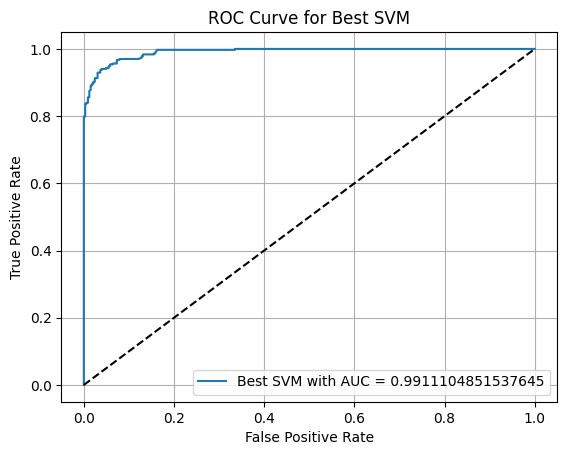

In [23]:
false_positive_rate, true_positive_rate, _ = roc_curve(y_test, predicted_probs)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure()
plt.plot(false_positive_rate, true_positive_rate, label=f"Best SVM with AUC = {roc_auc}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Best SVM")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# 9. a)

def analyze_logistic_classifier(model, test_features, test_labels, model_name=""):
    predicted_labels = model.predict(test_features)
    predicted_probs = model.predict_proba(test_features)[:, 1]

    conf_matrix = confusion_matrix(test_labels, predicted_labels)

    accuracy = accuracy_score(test_labels, predicted_labels)
    recall = recall_score(test_labels, predicted_labels)
    precision = precision_score(test_labels, predicted_labels)
    f1 = f1_score(test_labels, predicted_labels)

    false_positive_rate, true_positive_rate, _ = roc_curve(test_labels, predicted_probs)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    print(model_name)
    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1-score: {f1}\n")

    plt.plot(false_positive_rate, true_positive_rate, label=f"{model_name} with AUC={roc_auc:.3f}")

LogReg (no regularization)
Confusion Matrix:
[[310  18]
 [ 18 350]]
Accuracy: 0.9482758620689655
Recall: 0.9510869565217391
Precision: 0.9510869565217391
F1-score: 0.9510869565217391



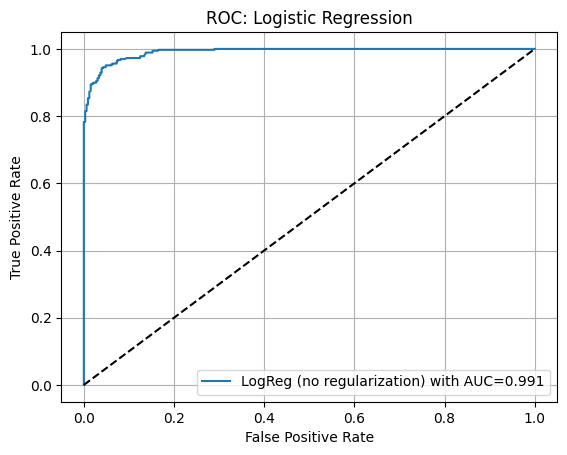

In [25]:
# Train a logistic classifier without regularization
no_regurlarization_logreg = LogisticRegression(penalty="l2", C=1e9, solver="lbfgs",max_iter=5000)
no_regurlarization_logreg.fit(X_train_lsi_25, y_train)

plt.figure()
analyze_logistic_classifier(no_regurlarization_logreg, X_test_lsi_25, y_test, "LogReg (no regularization)")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC: Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# 9. b) Find the optimal regularization coefficient

coefficients = [10**k for k in range(-5, 6)]

def find_optimal_regularization_coefficient(penalty_type):
    best_C = None
    best_cv_accuracy = -100.0

    for C in coefficients:
        if penalty_type == "l1":
            model = LogisticRegression(penalty="l1", C=C, solver="liblinear", max_iter=5000)
        else:
            model = LogisticRegression(penalty="l2", C=C, solver="lbfgs", max_iter=5000)

        scores = cross_val_score(model, X_train_lsi_25, y_train, cv=5, scoring="accuracy")
        avg_score = scores.mean()

        if avg_score > best_cv_accuracy:
            best_cv_accuracy = avg_score
            best_C = C

    return best_C, best_cv_accuracy

best_C_l1, best_acc_l1 = find_optimal_regularization_coefficient("l1")
best_C_l2, best_acc_l2 = find_optimal_regularization_coefficient("l2")

# 9. b) 1.
print("Optimal regularization coefficient for L1:", best_C_l1, "CV accuracy:", round(best_acc_l1, 4))
print("Optimal regularization coefficient for L2:", best_C_l2, "CV accuracy:", round(best_acc_l2, 4))

Optimal regularization coefficient for L1: 100 CV accuracy: 0.9514
Optimal regularization coefficient for L2: 100 CV accuracy: 0.9522


LogReg (no regularization)
Confusion Matrix:
[[310  18]
 [ 18 350]]
Accuracy: 0.9482758620689655
Recall: 0.9510869565217391
Precision: 0.9510869565217391
F1-score: 0.9510869565217391

LogReg L1, C=100
Confusion Matrix:
[[310  18]
 [ 18 350]]
Accuracy: 0.9482758620689655
Recall: 0.9510869565217391
Precision: 0.9510869565217391
F1-score: 0.9510869565217391

LogReg L2, C=100
Confusion Matrix:
[[309  19]
 [ 19 349]]
Accuracy: 0.9454022988505747
Recall: 0.9483695652173914
Precision: 0.9483695652173914
F1-score: 0.9483695652173914



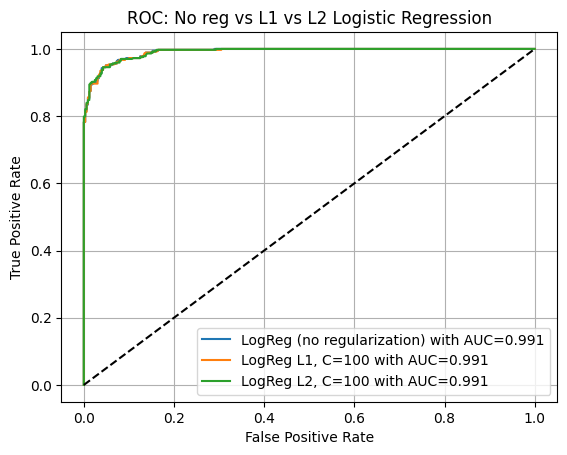

In [27]:
best_l1_logreg = LogisticRegression(penalty="l1", C=best_C_l1, solver="liblinear", max_iter=5000)
best_l2_logreg = LogisticRegression(penalty="l2", C=best_C_l2, solver="lbfgs", max_iter=5000)

best_l1_logreg.fit(X_train_lsi_25, y_train)
best_l2_logreg.fit(X_train_lsi_25, y_train)

plt.figure()
analyze_logistic_classifier(no_regurlarization_logreg,  X_test_lsi_25, y_test, "LogReg (no regularization)")
analyze_logistic_classifier(best_l1_logreg, X_test_lsi_25, y_test, f"LogReg L1, C={best_C_l1}")
analyze_logistic_classifier(best_l2_logreg, X_test_lsi_25, y_test, f"LogReg L2, C={best_C_l2}")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC: No reg vs L1 vs L2 Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()


9. b) 2.
Compare the performance (accuracy, precision, recall and F-1 score) of 3 logistic classi-
fiers: w/o regularization, w/ L1 regularization and w/ L2 regularization

    All three models performed pretty much the same way. L2 performed slightly worse and the confusion matrices were slightly different.

9. b) 3. 

How does the regularization parameter affect the test error?

    No substantial affect since the classes are already split after TF-IDF + LSI

How are the learnt coefficients affected?

    L1 makes some of the coefficients zero while L2 shrinks them in a stable manner.

Why might one be interested in each type of regularization?

    L1 is good for selecting features, L2 for better stability and robustness, and no regularization when you want it faster when there is no
    need to avoid overfitting.

9. b) 4.

Both logistic regression and linear SVM are trying to classify data points using a linear
decision boundary.

What is the difference between their ways to find this boundary?

    Logistic regression finds the boundary by maximizing the conditional likelihood. SVM maximizes the margins between each class instead.

Why do their performances differ?

    Logistic regression fits over all points and SVM only fits on the boundary support vectors.

Is this difference statistically significant?

    Based on the findings above, the difference is not significant.

In [28]:
def analyze_classifier(model, test_features, test_labels, model_name=''):
    predicted_labels = model.predict(test_features)
    
    if hasattr(model, 'predict_proba'):
        predicted_probs = model.predict_proba(test_features)[:, 1]
    elif hasattr(model, 'decision_function'):
        predicted_probs = model.decision_function(test_features)
    else:
        predicted_probs = predicted_labels

    conf_matrix = confusion_matrix(test_labels, predicted_labels)
    accuracy = accuracy_score(test_labels, predicted_labels)
    recall = recall_score(test_labels, predicted_labels)
    precision = precision_score(test_labels, predicted_labels)
    f1 = f1_score(test_labels, predicted_labels)

    fpr, tpr, _ = roc_curve(test_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)

    print(model_name)
    print('Confusion Matrix:')
    print(conf_matrix)
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'F1-score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print()

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')
    return accuracy, recall, precision, f1, roc_auc

GaussianNB (LSI features)
Confusion Matrix:
[[280  48]
 [ 10 358]]
Accuracy: 0.9167
Recall: 0.9728
Precision: 0.8818
F1-score: 0.9251
ROC AUC: 0.9742



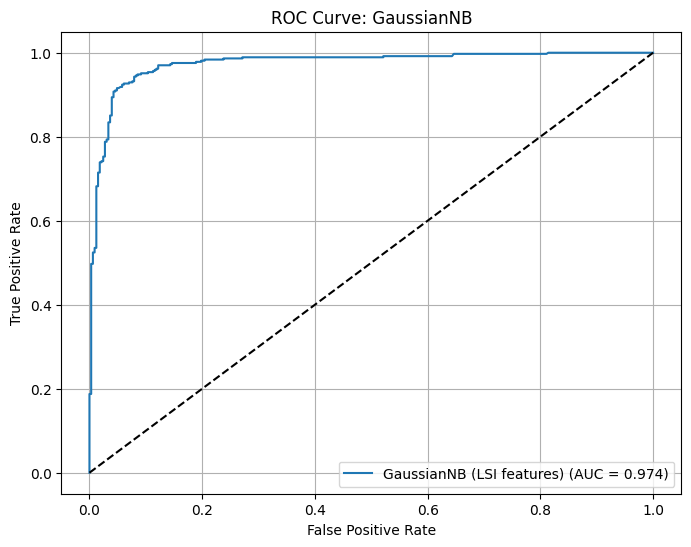

In [29]:
# QUESTION 10: Naive Bayes (GaussianNB)
from sklearn.naive_bayes import GaussianNB


gnb = GaussianNB()
gnb.fit(X_train_lsi_25, y_train)

plt.figure(figsize=(8, 6))
analyze_classifier(gnb, X_test_lsi_25, y_test, 'GaussianNB (LSI features)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: GaussianNB')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# QUESTION 11: GridSearch Pipeline for Binary Classification
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.filterwarnings('ignore')

class DenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if hasattr(X, 'toarray'):
            return X.toarray()
        return X

from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stem_tokenizer(text):
    tokens = word_tokenize(text.lower())
    tagged = pos_tag(tokens)
    
    stems = []
    for w, tag in tagged:
        if _num_like.match(w):
            continue
        if not any(ch.isalpha() for ch in w):
            continue
        stems.append(stemmer.stem(w))
    return stems

#Q8
best_svm_gamma = 2000
#Q9
best_lr_l1_C = 100
best_lr_l2_C = 100

param_grid_sparse = [
    # SVM configurations
    {
        'vect__min_df': [2, 5],
        'dim_red': [TruncatedSVD(n_components=5), TruncatedSVD(n_components=30), TruncatedSVD(n_components=100),
                    NMF(n_components=5, max_iter=200), NMF(n_components=30, max_iter=200), NMF(n_components=100, max_iter=200)],
        'clf': [LinearSVC(C=1.0/best_svm_gamma, max_iter=2000, dual='auto')],
    },
    # Logistic Regression L1
    {
        'vect__min_df': [2, 5],
        'dim_red': [TruncatedSVD(n_components=5), TruncatedSVD(n_components=30), TruncatedSVD(n_components=100),
                    NMF(n_components=5, max_iter=200), NMF(n_components=30, max_iter=200), NMF(n_components=100, max_iter=200)],
        'clf': [LogisticRegression(penalty='l1', C=best_lr_l1_C, solver='liblinear', max_iter=1000)],
    },
    # Logistic Regression L2
    {
        'vect__min_df': [2, 5],
        'dim_red': [TruncatedSVD(n_components=5), TruncatedSVD(n_components=30), TruncatedSVD(n_components=100),
                    NMF(n_components=5, max_iter=200), NMF(n_components=30, max_iter=200), NMF(n_components=100, max_iter=200)],
        'clf': [LogisticRegression(penalty='l2', C=best_lr_l2_C, solver='liblinear', max_iter=1000)],
    },
]

param_grid_dense = [
    # GaussianNB configurations
    {
        'vect__min_df': [2, 5],
        'dim_red': [TruncatedSVD(n_components=5), TruncatedSVD(n_components=30), TruncatedSVD(n_components=100),
                    NMF(n_components=5, max_iter=200), NMF(n_components=30, max_iter=200), NMF(n_components=100, max_iter=200)],
        'clf': [GaussianNB()],
    },
]

# Store all results
all_results = []

# Pipeline for sparse classifiers with LEMMATIZER
pipeline_sparse_lemma = Pipeline([
    ('vect', CountVectorizer(stop_words='english', tokenizer=lemma_tokenizer, token_pattern=None)),
    ('tfidf', TfidfTransformer()),
    ('dim_red', TruncatedSVD(n_components=5)),
    ('clf', LinearSVC())
])

# Pipeline for GaussianNB with LEMMATIZER
pipeline_dense_lemma = Pipeline([
    ('vect', CountVectorizer(stop_words='english', tokenizer=lemma_tokenizer, token_pattern=None)),
    ('tfidf', TfidfTransformer()),
    ('dim_red', TruncatedSVD(n_components=5)),
    ('to_dense', DenseTransformer()),
    ('clf', GaussianNB())
])

print('Gridsearch svm and logistic')
grid_sparse_lemma = GridSearchCV(
    pipeline_sparse_lemma,
    param_grid_sparse,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    verbose=2
)
grid_sparse_lemma.fit(train_texts_clean, y_train)

print('\nGridsearch gaussian')
grid_dense_lemma = GridSearchCV(
    pipeline_dense_lemma,
    param_grid_dense,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    verbose=2
)
grid_dense_lemma.fit(train_texts_clean, y_train)

import pandas as pd
results_sparse_lemma = pd.DataFrame(grid_sparse_lemma.cv_results_)
results_sparse_lemma['tokenizer'] = 'lemmatizer'
results_dense_lemma = pd.DataFrame(grid_dense_lemma.cv_results_)
results_dense_lemma['tokenizer'] = 'lemmatizer'
all_results.extend([results_sparse_lemma, results_dense_lemma])

# Pipeline for sparse classifiers with STEMMER
pipeline_sparse_stem = Pipeline([
    ('vect', CountVectorizer(stop_words='english', tokenizer=stem_tokenizer, token_pattern=None)),
    ('tfidf', TfidfTransformer()),
    ('dim_red', TruncatedSVD(n_components=5)),
    ('clf', LinearSVC())
])

# Pipeline for GaussianNB with STEMMER
pipeline_dense_stem = Pipeline([
    ('vect', CountVectorizer(stop_words='english', tokenizer=stem_tokenizer, token_pattern=None)),
    ('tfidf', TfidfTransformer()),
    ('dim_red', TruncatedSVD(n_components=5)),
    ('to_dense', DenseTransformer()),
    ('clf', GaussianNB())
])

print('\nGridsearch svm and logistic')
grid_sparse_stem = GridSearchCV(
    pipeline_sparse_stem,
    param_grid_sparse,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    verbose=2
)
grid_sparse_stem.fit(train_texts_clean, y_train)

print('\nGridsearch gaussian')
grid_dense_stem = GridSearchCV(
    pipeline_dense_stem,
    param_grid_dense,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    verbose=2
)
grid_dense_stem.fit(train_texts_clean, y_train)

results_sparse_stem = pd.DataFrame(grid_sparse_stem.cv_results_)
results_sparse_stem['tokenizer'] = 'stemmer'
results_dense_stem = pd.DataFrame(grid_dense_stem.cv_results_)
results_dense_stem['tokenizer'] = 'stemmer'
all_results.extend([results_sparse_stem, results_dense_stem])

# Combine results
all_results_df = pd.concat(all_results, ignore_index=True)
all_results_sorted = all_results_df.sort_values('mean_test_score', ascending=False)

print('\n' + '='*80)
print('TOP 5 5-fold CV ACC')
print('='*80)

# Display top 5
for idx, (i, row) in enumerate(all_results_sorted.head(5).iterrows(), 1):
    print(f'\nRank {idx}:')
    print(f"  CV Accuracy: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    print(f"  Parameters: {row['params']}")

print('\n' + '='*80)
print('TEST SET TOP 5 COMBINATIONS')
print('='*80)

test_results = []

for idx, (i, row) in enumerate(all_results_sorted.head(5).iterrows(), 1):
    print(f'\n--- Rank {idx} ---')
    params = row['params']
    tokenizer_type = row['tokenizer']
    
    clf = params.get('clf')
    if isinstance(clf, GaussianNB):
        if tokenizer_type == 'lemmatizer':
            pipeline = pipeline_dense_lemma
        else:
            pipeline = pipeline_dense_stem
    else:
        if tokenizer_type == 'lemmatizer':
            pipeline = pipeline_sparse_lemma
        else:
            pipeline = pipeline_sparse_stem
    
    pipeline.set_params(**params)
    pipeline.fit(train_texts_clean, y_train)
    
    y_pred = pipeline.predict(test_texts_clean)
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
    
    test_acc = accuracy_score(y_test, y_pred)
    test_prec = precision_score(y_test, y_pred, average='binary')
    test_rec = recall_score(y_test, y_pred, average='binary')
    test_f1 = f1_score(y_test, y_pred, average='binary')
    conf_mat = confusion_matrix(y_test, y_pred)
    
    print(f'Parameters: {params}')
    print(f'\nTest Set Metrics:')
    print(f'  Accuracy:  {test_acc:.4f}')
    print(f'  Precision: {test_prec:.4f}')
    print(f'  Recall:    {test_rec:.4f}')
    print(f'  F1-Score:  {test_f1:.4f}')
    print(f'\nConfusion Matrix:')
    print(conf_mat)
    
    test_results.append({
        'rank': idx,
        'params': params,
        'cv_acc': row['mean_test_score'],
        'test_acc': test_acc,
        'test_prec': test_prec,
        'test_rec': test_rec,
        'test_f1': test_f1
    })

# Summary table
print('\n' + '='*80)
print('SUMMARY')
print('='*80)
summary_df = pd.DataFrame(test_results)
print(summary_df[['rank', 'cv_acc', 'test_acc', 'test_prec', 'test_rec', 'test_f1']].to_string(index=False))

Gridsearch svm and logistic
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END clf=LinearSVC(C=0.0005, max_iter=2000), dim_red=TruncatedSVD(n_components=5), vect__min_df=2; total time= 1.7min
[CV] END clf=LinearSVC(C=0.0005, max_iter=2000), dim_red=TruncatedSVD(n_components=5), vect__min_df=2; total time= 1.7min
[CV] END clf=LinearSVC(C=0.0005, max_iter=2000), dim_red=TruncatedSVD(n_components=5), vect__min_df=2; total time= 1.7min
[CV] END clf=LinearSVC(C=0.0005, max_iter=2000), dim_red=TruncatedSVD(n_components=5), vect__min_df=2; total time= 1.7min
[CV] END clf=LinearSVC(C=0.0005, max_iter=2000), dim_red=TruncatedSVD(n_components=5), vect__min_df=2; total time= 1.7min
[CV] END clf=LinearSVC(C=0.0005, max_iter=2000), dim_red=TruncatedSVD(n_components=5), vect__min_df=5; total time= 1.7min
[CV] END clf=LinearSVC(C=0.0005, max_iter=2000), dim_red=TruncatedSVD(n_components=5), vect__min_df=5; total time= 1.7min
[CV] END clf=LinearSVC(C=0.0005, max_iter=2000), dim_red

KeyboardInterrupt: 

Gridsearch svm and logistic
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Gridsearch gaussian
Fitting 5 folds for each of 24 candidates, totalling 120 fits

================================================================================
TOP 5 5-fold CV ACC
================================================================================

Rank 1:
  CV Accuracy: 0.9604 (+/- 0.0032)
  Parameters: {'clf': LogisticRegression(C=100, max_iter=1000, penalty='l2', solver='liblinear'), 'dim_red': TruncatedSVD(n_components=100), 'vect__min_df': 5, 'vect__tokenizer': <__main__.StemTokenizer object at 0x000002A3CC9F0EC0>}

Rank 2:
  CV Accuracy: 0.9601 (+/- 0.0053)
  Parameters: {'clf': LogisticRegression(C=100, max_iter=1000, penalty='l1', solver='liblinear'), 'dim_red': NMF(n_components=100, tol=0.01), 'vect__min_df': 2, 'vect__tokenizer': <__main__.StemTokenizer object at 0x000002A3CC9F0EC0>}

Rank 3:
  CV Accuracy: 0.9601 (+/- 0.0026)
  Parameters: {'clf': LogisticRegression(C=100, max_iter=1000, penalty='l2', solver='liblinear'), 'dim_red': TruncatedSVD(n_components=100), 'vect__min_df': 2, 'vect__tokenizer': <__main__.LemmaTokenizer object at 0x000002A3CC9F06E0>}

Rank 4:
  CV Accuracy: 0.9601 (+/- 0.0035)
  Parameters: {'clf': LogisticRegression(C=100, max_iter=1000, penalty='l2', solver='liblinear'), 'dim_red': TruncatedSVD(n_components=100), 'vect__min_df': 5, 'vect__tokenizer': <__main__.LemmaTokenizer object at 0x000002A3CC9F06E0>}

Rank 5:
  CV Accuracy: 0.9597 (+/- 0.0040)
  Parameters: {'clf': LogisticRegression(C=100, max_iter=1000, penalty='l1', solver='liblinear'), 'dim_red': TruncatedSVD(n_components=100), 'vect__min_df': 2, 'vect__tokenizer': <__main__.LemmaTokenizer object at 0x000002A3CC9F06E0>}

================================================================================
TEST SET TOP 5 COMBINATIONS
================================================================================

--- Rank 1 ---
Parameters: {'clf': LogisticRegression(C=100, max_iter=1000, penalty='l2', solver='liblinear'), 'dim_red': TruncatedSVD(n_components=100), 'vect__min_df': 5, 'vect__tokenizer': <__main__.StemTokenizer object at 0x000002A3CC9F0EC0>}

Test Set Metrics:
  Accuracy:  0.9670
  Precision: 0.9778
  Recall:    0.9592
  F1-Score:  0.9684

Confusion Matrix:
[[320   8]
 [ 15 353]]

--- Rank 2 ---
Parameters: {'clf': LogisticRegression(C=100, max_iter=1000, penalty='l1', solver='liblinear'), 'dim_red': NMF(n_components=100, tol=0.01), 'vect__min_df': 2, 'vect__tokenizer': <__main__.StemTokenizer object at 0x000002A3CC9F0EC0>}

Test Set Metrics:
  Accuracy:  0.9569
  Precision: 0.9669
  Recall:    0.9511
  F1-Score:  0.9589

Confusion Matrix:
[[316  12]
 [ 18 350]]

--- Rank 3 ---
Parameters: {'clf': LogisticRegression(C=100, max_iter=1000, penalty='l2', solver='liblinear'), 'dim_red': TruncatedSVD(n_components=100), 'vect__min_df': 2, 'vect__tokenizer': <__main__.LemmaTokenizer object at 0x000002A3CC9F06E0>}

Test Set Metrics:
  Accuracy:  0.9727
  Precision: 0.9861
  Recall:    0.9620
  F1-Score:  0.9739

Confusion Matrix:
[[323   5]
 [ 14 354]]

--- Rank 4 ---
Parameters: {'clf': LogisticRegression(C=100, max_iter=1000, penalty='l2', solver='liblinear'), 'dim_red': TruncatedSVD(n_components=100), 'vect__min_df': 5, 'vect__tokenizer': <__main__.LemmaTokenizer object at 0x000002A3CC9F06E0>}

Test Set Metrics:
  Accuracy:  0.9670
  Precision: 0.9778
  Recall:    0.9592
  F1-Score:  0.9684

Confusion Matrix:
[[320   8]
 [ 15 353]]

--- Rank 5 ---
Parameters: {'clf': LogisticRegression(C=100, max_iter=1000, penalty='l1', solver='liblinear'), 'dim_red': TruncatedSVD(n_components=100), 'vect__min_df': 2, 'vect__tokenizer': <__main__.LemmaTokenizer object at 0x000002A3CC9F06E0>}

Test Set Metrics:
  Accuracy:  0.9670
  Precision: 0.9832
  Recall:    0.9538
  F1-Score:  0.9683

Confusion Matrix:
[[322   6]
 [ 17 351]]

================================================================================
SUMMARY
================================================================================
 rank   cv_acc  test_acc  test_prec  test_rec  test_f1
    1 0.960432  0.966954   0.977839  0.959239 0.968450
    2 0.960072  0.956897   0.966851  0.951087 0.958904
    3 0.960072  0.972701   0.986072  0.961957 0.973865
    4 0.960072  0.966954   0.977839  0.959239 0.968450
    5 0.959712  0.966954   0.983193  0.953804 0.968276


In [31]:
# TAKEN FROM QUESTION 5: GloVe Embeddings
import numpy as np
import os

embeddings_dict = {}
glove_path = 'glove.6B.300d.txt' 

print('Loading GloVe embeddings...')
if os.path.exists(glove_path):
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], 'float32')
            embeddings_dict[word] = vector
    print(f'Loaded {len(embeddings_dict)} word vectors.')
else:
    print(f'Error: {glove_path} not found. Please ensure the file is in the correct directory.')

def get_glove_embedding(text, embeddings_dict, dim=300):
    words = text.split()
    valid_vectors = []
    for w in words:
        if w in embeddings_dict:
            valid_vectors.append(embeddings_dict[w])
    
    if not valid_vectors:
        return np.zeros(dim)
    
    return np.mean(valid_vectors, axis=0)

print('Constructing GloVe document embeddings...')
if embeddings_dict:
    X_train_glove = np.array([get_glove_embedding(t, embeddings_dict) for t in train_texts_clean])
    X_test_glove = np.array([get_glove_embedding(t, embeddings_dict) for t in test_texts_clean])

    print('GloVe train shape:', X_train_glove.shape)
    print('GloVe test shape:', X_test_glove.shape)
else:
    X_train_glove = np.zeros((len(train_texts_clean), 300))
    X_test_glove = np.zeros((len(test_texts_clean), 300))
    print('GloVe embeddings dict empty, using zeros.')

Loading GloVe embeddings...
Loaded 400000 word vectors.
Constructing GloVe document embeddings...
GloVe train shape: (2780, 300)
GloVe test shape: (696, 300)


In [32]:
# TAKEN FROM QUESTION 6: LLM Embeddings
import torch
from transformers import AutoTokenizer, AutoModel

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'
MAX_LEN = 128
BATCH_SIZE = 32

print(f'Loading {MODEL_NAME}...')
try:
    tok = AutoTokenizer.from_pretrained(MODEL_NAME)
    enc = AutoModel.from_pretrained(MODEL_NAME).to(device)
    enc.eval()

    @torch.no_grad()
    def get_llm_embeddings(texts):
        all_vecs = []
        for i in range(0, len(texts), BATCH_SIZE):
            batch = texts[i:i+BATCH_SIZE]
            inputs = tok(
                batch,
                truncation=True,
                max_length=MAX_LEN,
                padding=True,
                return_tensors='pt'
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}
            out = enc(**inputs)
            
            # Mean pooling
            mask = inputs['attention_mask'].unsqueeze(-1).expand(out.last_hidden_state.size()).float()
            sum_embeddings = torch.sum(out.last_hidden_state * mask, 1)
            sum_mask = torch.clamp(mask.sum(1), min=1e-9)
            pooled = sum_embeddings / sum_mask
            
            all_vecs.append(pooled.cpu().numpy())
            
        return np.concatenate(all_vecs, axis=0)

    # Use raw texts for LLM
    print('Generating LLM embeddings for Train set...')
    X_train_llm = get_llm_embeddings(train_texts)
    print('Generating LLM embeddings for Test set...')
    X_test_llm = get_llm_embeddings(test_texts)

    print('LLM train shape:', X_train_llm.shape)
    print('LLM test shape:', X_test_llm.shape)

except Exception as e:
    print(f'Error loading/running LLM: {e}')
    # Fallback
    X_train_llm = np.zeros((len(train_texts), 384))
    X_test_llm = np.zeros((len(test_texts), 384))

Using device: cuda
Loading sentence-transformers/all-MiniLM-L6-v2...
Generating LLM embeddings for Train set...
Generating LLM embeddings for Test set...
LLM train shape: (2780, 384)
LLM test shape: (696, 384)


QUESTION 12: Representation Comparison
Building TF-IDF pipeline best
--------------------------------------------------------------------------------
TF-IDF (best pipeline) train shape: (2780, 100)
TF-IDF (best pipeline) test shape: (696, 100)

Setting up classifier
--------------------------------------------------------------------------------
Classifier for all representations: LogisticRegression(C=100, max_iter=1000, random_state=42, solver='liblinear')
--------------------------------------------------------------------------------
TF-IDF (Best from Q11)    - Train: (2780, 100), Test: (696, 100)
GloVe                     - Train: (2780, 300), Test: (696, 300)
LLM (MiniLM)              - Train: (2780, 384), Test: (696, 384)

EVALUATION RESULTS - ALL REPRESENTATIONS

--- Training on TF-IDF (Best from Q11) ---
TF-IDF (Best from Q11)
Confusion Matrix:
[[321   7]
 [ 14 354]]
Accuracy: 0.9698
Recall: 0.9620
Precision: 0.9806
F1-score: 0.9712
ROC AUC: 0.9961


--- Training on GloVe ---
G

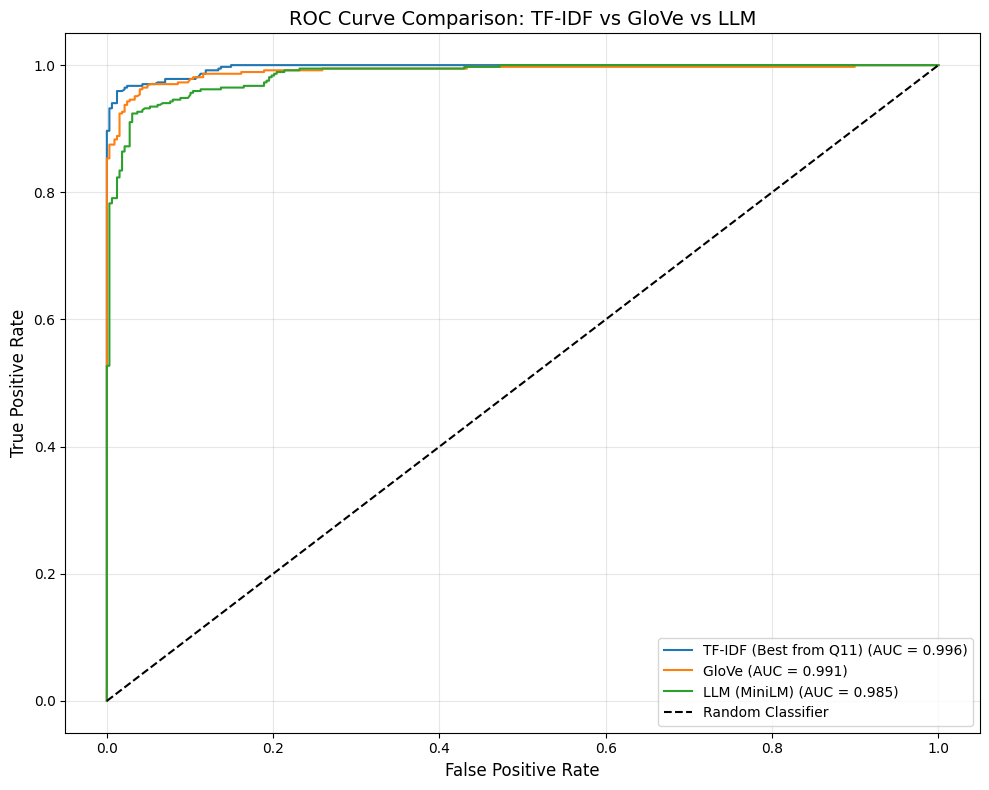


SUMMARY COMPARISON TABLE
        Representation  Accuracy  Precision   Recall  F1-Score
TF-IDF (Best from Q11)  0.969828   0.980609 0.961957  0.971193
                 GloVe  0.955460   0.969359 0.945652  0.957359
          LLM (MiniLM)  0.939655   0.952778 0.932065  0.942308

Best representation: TF-IDF (Best from Q11) (F1: 0.9712)
Worst representation: LLM (MiniLM) (F1: 0.9423)


In [33]:
# QUESTION 12:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

print("="*80)
print("QUESTION 12: Representation Comparison")
print("="*80)


print("Building TF-IDF pipeline best")
print("-"*80)

# Use LemmaTokenizer (same as in Q11)
best_tfidf_pipeline = Pipeline([
    ('vect', CountVectorizer(
        stop_words='english',
        token_pattern=None,
        min_df=2,
        tokenizer=lemma_tokenizer
    )),
    ('tfidf', TfidfTransformer()),
    ('dim_red', TruncatedSVD(n_components=100))
])

X_train_tfidf_best = best_tfidf_pipeline.fit_transform(train_texts_clean, y_train)
X_test_tfidf_best = best_tfidf_pipeline.transform(test_texts_clean)

if hasattr(X_train_tfidf_best, 'toarray'):
    X_train_tfidf_best = X_train_tfidf_best.toarray()
    X_test_tfidf_best = X_test_tfidf_best.toarray()

print(f"TF-IDF (best pipeline) train shape: {X_train_tfidf_best.shape}")
print(f"TF-IDF (best pipeline) test shape: {X_test_tfidf_best.shape}")

print("\nSetting up classifier")
print("-"*80)

# Use LogisticRegression with L2 and C=100 (the best from Q11)
clf_q12 = LogisticRegression(
    penalty='l2',
    C=100,
    solver='liblinear',
    max_iter=1000,
    random_state=42
)
print(f"Classifier for all representations: {clf_q12}")


print("-"*80)

representations = {
    'TF-IDF (Best from Q11)': (X_train_tfidf_best, X_test_tfidf_best),
    'GloVe': (X_train_glove, X_test_glove),
    'LLM (MiniLM)': (X_train_llm, X_test_llm)
}

for name, (X_tr, X_te) in representations.items():
    print(f"{name:25s} - Train: {X_tr.shape}, Test: {X_te.shape}")


print("\n" + "="*80)
print("EVALUATION RESULTS - ALL REPRESENTATIONS")
print("="*80)

results_dict = {}
plt.figure(figsize=(10, 8))

for name, (X_tr, X_te) in representations.items():
    print(f'\n--- Training on {name} ---')
    
    # dim check
    if X_tr.shape[0] != y_train.shape[0]:
        print(f'ERROR: Skipping {name} due to dimension mismatch.')
        continue
    
    clf_q12.fit(X_tr, y_train)
    
    analyze_classifier(clf_q12, X_te, y_test, name)
    
    y_pred = clf_q12.predict(X_te)
    results_dict[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

# ROC plot
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison: TF-IDF vs GloVe vs LLM', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("SUMMARY COMPARISON TABLE")
print("="*80)

import pandas as pd

summary_data = []
for name, metrics in results_dict.items():
    summary_data.append({
        'Representation': name,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1']
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

best_rep = max(results_dict.items(), key=lambda x: x[1]['f1'])
worst_rep = min(results_dict.items(), key=lambda x: x[1]['f1'])

print(f"\nBest representation: {best_rep[0]} (F1: {best_rep[1]['f1']:.4f})")
print(f"Worst representation: {worst_rep[0]} (F1: {worst_rep[1]['f1']:.4f})")

Running UMAP


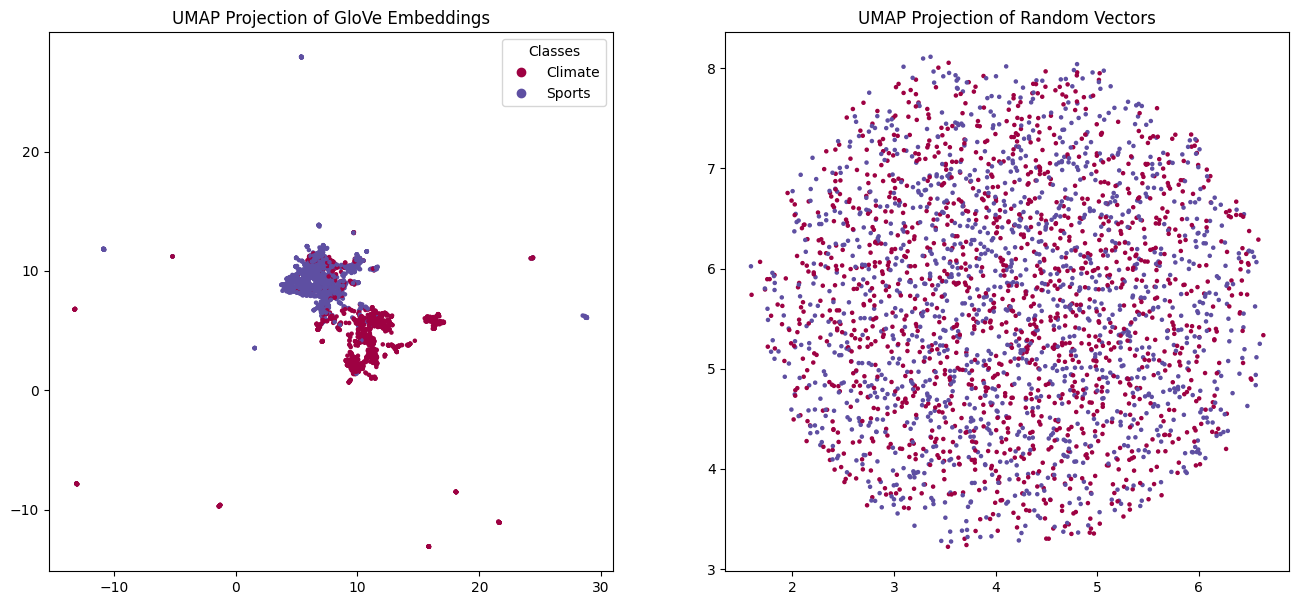

In [34]:
# QUESTION 13 UMAP:
try:
    import umap.umap_ as umap
except ImportError:

    import subprocess
    import sys
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'umap-learn'])
        import umap.umap_ as umap
    except Exception as e:
        print(f'Failed to install/import umap: {e}. Visualization skipped.')
        umap = None

if umap:
    print("Running UMAP")
    reducer = umap.UMAP(random_state=42)
    embedding_glove = reducer.fit_transform(X_train_glove)
    X_random = np.random.rand(*X_train_glove.shape)
    embedding_random = reducer.fit_transform(X_random)

    fig, axs = plt.subplots(1, 2, figsize=(16, 7))
    scatter = axs[0].scatter(embedding_glove[:, 0], embedding_glove[:, 1], c=y_train, cmap='Spectral', s=5)
    axs[0].set_title('UMAP Projection of GloVe Embeddings')
    handles, _ = scatter.legend_elements(prop='colors')
    labels = ['Climate', 'Sports'] 
    axs[0].legend(handles, labels, title='Classes')

    #Random Plot
    axs[1].scatter(embedding_random[:, 0], embedding_random[:, 1], c=y_train, cmap='Spectral', s=5)
    axs[1].set_title('UMAP Projection of Random Vectors')

    plt.show()


### Question 13

The GloVe embeddings plot (left) shows two distinct, well-separated clusters corresponding to the Sports (blue) and Climate (pink) classes, with minimal overlap and only a few scattered outliers. The clusters are compact and clearly separable, indicating that GloVe embeddings successfully capture semantic meaning.

In [35]:
# 14.

map_row_to_class = {
    0:"basketball", 1:"baseball", 2:"tennis", 3:"football", 4:"soccer",
    5:"forest fire", 6:"flood", 7:"earthquake", 8:"drought", 9:"heatwave"
}
class_to_index = {name: idx for idx, name in map_row_to_class.items()}

y_train_leaf = train_df["leaf_label"].map(class_to_index).to_numpy()
y_test_leaf  = test_df["leaf_label"].map(class_to_index).to_numpy()

train_features = X_train_lsi_25
test_features  = X_test_lsi_25

In [36]:
def analyze_multiclass_models(model_name, true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels, labels=list(range(10)))
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average="macro", zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average="macro", zero_division=0)
    f1_score_value = f1_score(true_labels, predicted_labels, average="macro", zero_division=0)

    print(model_name)
    print("Accuracy:", accuracy)
    print("Macro Precision:", precision)
    print("Macro Recall:", recall)
    print("Macro F1:", f1_score_value)
    print("\nConfusion Matrix:")
    print(cm, '\n')
    return cm, accuracy, precision, recall, f1_score_value

In [37]:
# 14. b) 

nb_model = MultinomialNB()
if np.min(train_features) < 0:
    shift = -np.min(train_features)
    train_nb = train_features + shift
    test_nb = test_features + shift
else:
    train_nb = train_features
    test_nb = test_features
nb_model.fit(train_nb, y_train_leaf)
nb_pred = nb_model.predict(test_nb)
analyze_multiclass_models("MultinomialNB", y_test_leaf, nb_pred)

ovo_model = OneVsOneClassifier(LinearSVC(C=1.0, max_iter=5000))
ovo_model.fit(train_features, y_train_leaf)
ovo_pred = ovo_model.predict(test_features)
cm_ovo, acc_ovo, *_ = analyze_multiclass_models("SVM OvO", y_test_leaf, ovo_pred)

ovr_model = OneVsRestClassifier(LinearSVC(C=1.0, max_iter=5000))
ovr_model.fit(train_features, y_train_leaf)
ovr_pred = ovr_model.predict(test_features)
cm_ovr, acc_ovr, *_ = analyze_multiclass_models("SVM OvR", y_test_leaf, ovr_pred)

MultinomialNB
Accuracy: 0.5718390804597702
Macro Precision: 0.7676994485657599
Macro Recall: 0.5953901951653174
Macro F1: 0.5657230301591989

Confusion Matrix:
[[36  0 45  7  0  0  0  0  0  2]
 [ 0  6 56  3  0  0  2  0  0  8]
 [ 0  0 60  1  2  0  0  0  0  6]
 [ 0  0  3 58  0  0  0  0  0  0]
 [ 0  0 18  4 51  0  0  0  0  0]
 [ 0  0  8  0  0  1  0  0  1 63]
 [ 0  0  2  0  0  0 58  0  0  6]
 [ 0  0  6  0  0  0  0 44  0  4]
 [ 0  0  4  0  0  0  1  4 28 31]
 [ 0  0  9  0  0  1  1  0  0 56]] 

SVM OvO
Accuracy: 0.7255747126436781
Macro Precision: 0.7448280405607174
Macro Recall: 0.7280075302134545
Macro F1: 0.7315837414138835

Confusion Matrix:
[[75 11  2  2  0  0  0  0  0  0]
 [ 2 59  7  1  0  3  1  0  0  2]
 [ 0 12 52  0  3  1  1  0  0  0]
 [ 0  2  0 57  2  0  0  0  0  0]
 [ 0  4  6  2 61  0  0  0  0  0]
 [ 0  5  5  0  0 18  0  0  4 41]
 [ 0  2  0  0  0  3 59  0  0  2]
 [ 0  1  8  0  0  0  0 44  0  1]
 [ 0  2  2  0  0  0  0  0 59  5]
 [ 0  4  6  0  0 33  1  0  2 21]] 

SVM OvR
Accuracy: 0.

14. c)

There is a clear structure in the diagnol, where very similar classes like heatwave and forest fire have the most errors. This means these are harder to separate than the rest.

In [38]:
# 14. d)

classes_to_merge = ["forest fire", "heatwave"]
merge_ids = {class_to_index[name] for name in classes_to_merge}

new_label_map = {}
new_label_names = ["forestfire_heatwave"]

for old_id in merge_ids:
    new_label_map[old_id] = 0

next_label_id = 1
for old_id in range(10):
    if old_id in merge_ids:
        continue
    new_label_map[old_id] = next_label_id
    new_label_names.append(map_row_to_class[old_id])
    next_label_id += 1

num_classes_new = next_label_id

y_train_merged = np.array([new_label_map[y] for y in y_train_leaf])
y_test_merged  = np.array([new_label_map[y] for y in y_test_leaf])

print("New number of classes:", num_classes_new)
print("New label order:", new_label_names)

New number of classes: 9
New label order: ['forestfire_heatwave', 'basketball', 'baseball', 'tennis', 'football', 'soccer', 'flood', 'earthquake', 'drought']


In [39]:
# Train multiclass SVMs on merged labels
svm_ovo = OneVsOneClassifier(LinearSVC(C=1.0, max_iter=5000))
svm_ovr = OneVsRestClassifier(LinearSVC(C=1.0, max_iter=5000))

svm_ovo.fit(X_train_lsi_25, y_train_merged)
svm_ovr.fit(X_train_lsi_25, y_train_merged)

pred_ovo = svm_ovo.predict(X_test_lsi_25)
pred_ovr = svm_ovr.predict(X_test_lsi_25)

cm_ovo = confusion_matrix(y_test_merged, pred_ovo)
cm_ovr = confusion_matrix(y_test_merged, pred_ovr)

acc_ovo = accuracy_score(y_test_merged, pred_ovo)
acc_ovr = accuracy_score(y_test_merged, pred_ovr)

print("\nMerged OvO accuracy:", round(acc_ovo, 4))
print("Merged OvR accuracy:", round(acc_ovr, 4))
print("\nMerged OvO confusion matrix:\n", cm_ovo)
print("\nMerged OvR confusion matrix:\n", cm_ovr)


Merged OvO accuracy: 0.842
Merged OvR accuracy: 0.8391

Merged OvO confusion matrix:
 [[129   0   2   3   0   0   1   0   5]
 [  2  75  11   0   2   0   0   0   0]
 [ 11   2  56   4   1   0   1   0   0]
 [ 10   0   6  49   0   3   1   0   0]
 [  1   0   1   0  57   2   0   0   0]
 [  0   0   5   5   2  61   0   0   0]
 [  7   0   1   0   0   0  58   0   0]
 [  8   0   0   2   0   0   0  44   0]
 [ 10   0   0   1   0   0   0   0  57]]

Merged OvR confusion matrix:
 [[126   0   0   3   0   3   2   0   6]
 [  2  80   4   1   3   0   0   0   0]
 [ 10  10  43   6   2   2   1   0   1]
 [ 10   2   2  47   0   6   2   0   0]
 [  0   1   1   0  58   1   0   0   0]
 [  1   0   1   3   3  65   0   0   0]
 [  4   0   1   0   0   0  61   0   0]
 [  7   0   0   0   0   1   0  46   0]
 [  9   0   1   0   0   0   0   0  58]]


14. d)

After merging, the accuracy goes up quite a bit. 

In [40]:
# 14. e)
def evaluate_svm(model_name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    accuracy = accuracy_score(y_test, preds)
    cm  = confusion_matrix(y_test, preds)

    print(f"\n{model_name}")
    print("Accuracy:",accuracy)
    print("Confusion Matrix:\n", cm)

    return accuracy, cm

In [41]:
# before merging

svm_ovo_bal = OneVsOneClassifier(LinearSVC(C=1.0, class_weight="balanced", max_iter=5000))
svm_ovr_bal = OneVsRestClassifier(LinearSVC(C=1.0, class_weight="balanced", max_iter=5000))
evaluate_svm("Balanced SVM OvO (before merge)", svm_ovo_bal,X_train_lsi_25, y_train_leaf, X_test_lsi_25, y_test_leaf)
evaluate_svm("Balanced SVM OvR (before merge)", svm_ovr_bal,X_train_lsi_25, y_train_leaf, X_test_lsi_25, y_test_leaf)


Balanced SVM OvO (before merge)
Accuracy: 0.728448275862069
Confusion Matrix:
 [[75 11  2  2  0  0  0  0  0  0]
 [ 2 60  6  1  0  3  1  0  0  2]
 [ 0 12 52  0  3  1  1  0  0  0]
 [ 0  2  0 57  2  0  0  0  0  0]
 [ 0  4  6  2 61  0  0  0  0  0]
 [ 0  5  5  0  0 21  0  0  4 38]
 [ 0  2  0  0  0  3 59  0  0  2]
 [ 0  1  8  0  0  0  0 44  0  1]
 [ 0  3  1  0  0  0  0  0 59  5]
 [ 0  4  6  0  0 35  1  0  2 19]]

Balanced SVM OvR (before merge)
Accuracy: 0.7442528735632183
Confusion Matrix:
 [[76  7  5  2  0  0  0  0  0  0]
 [ 5 56  7  1  0  4  1  0  1  0]
 [ 0  9 53  0  4  1  1  0  0  1]
 [ 0  2  0 58  1  0  0  0  0  0]
 [ 0  1  5  2 65  0  0  0  0  0]
 [ 0  4  2  0  2 23  0  1  4 37]
 [ 0  1  0  0  0  2 63  0  0  0]
 [ 0  4  3  0  1  0  0 45  0  1]
 [ 0  3  1  0  0  0  0  0 60  4]
 [ 0  4  7  0  1 32  2  0  2 19]]


(0.7442528735632183,
 array([[76,  7,  5,  2,  0,  0,  0,  0,  0,  0],
        [ 5, 56,  7,  1,  0,  4,  1,  0,  1,  0],
        [ 0,  9, 53,  0,  4,  1,  1,  0,  0,  1],
        [ 0,  2,  0, 58,  1,  0,  0,  0,  0,  0],
        [ 0,  1,  5,  2, 65,  0,  0,  0,  0,  0],
        [ 0,  4,  2,  0,  2, 23,  0,  1,  4, 37],
        [ 0,  1,  0,  0,  0,  2, 63,  0,  0,  0],
        [ 0,  4,  3,  0,  1,  0,  0, 45,  0,  1],
        [ 0,  3,  1,  0,  0,  0,  0,  0, 60,  4],
        [ 0,  4,  7,  0,  1, 32,  2,  0,  2, 19]]))

In [42]:
# after merging

svm_ovo_bal_merged = OneVsOneClassifier(LinearSVC(C=1.0, class_weight="balanced", max_iter=5000))
svm_ovr_bal_merged = OneVsRestClassifier(LinearSVC(C=1.0, class_weight="balanced", max_iter=5000))
evaluate_svm("Balanced SVM OvO (after merge)", svm_ovo_bal_merged, X_train_lsi_25, y_train_merged, X_test_lsi_25, y_test_merged)
evaluate_svm("Balanced SVM OvR (after merge)", svm_ovr_bal_merged, X_train_lsi_25, y_train_merged, X_test_lsi_25, y_test_merged)


Balanced SVM OvO (after merge)
Accuracy: 0.8362068965517241
Confusion Matrix:
 [[114   0   9  10   0   0   1   0   6]
 [  0  75  11   2   2   0   0   0   0]
 [  5   2  60   6   1   0   1   0   0]
 [  1   0  12  52   0   3   1   0   0]
 [  0   0   2   0  57   2   0   0   0]
 [  0   0   5   5   2  61   0   0   0]
 [  4   0   2   0   0   0  60   0   0]
 [  1   0   1   8   0   0   0  44   0]
 [  4   0   4   1   0   0   0   0  59]]

Balanced SVM OvR (after merge)
Accuracy: 0.8390804597701149
Confusion Matrix:
 [[114   0   7   8   0   3   1   1   6]
 [  0  76   7   5   2   0   0   0   0]
 [  5   5  55   7   1   0   1   0   1]
 [  4   0   9  51   0   4   1   0   0]
 [  0   0   2   0  58   1   0   0   0]
 [  0   0   1   5   2  65   0   0   0]
 [  4   0   1   0   0   0  61   0   0]
 [  1   0   4   3   0   1   0  45   0]
 [  5   0   3   1   0   0   0   0  59]]


(0.8390804597701149,
 array([[114,   0,   7,   8,   0,   3,   1,   1,   6],
        [  0,  76,   7,   5,   2,   0,   0,   0,   0],
        [  5,   5,  55,   7,   1,   0,   1,   0,   1],
        [  4,   0,   9,  51,   0,   4,   1,   0,   0],
        [  0,   0,   2,   0,  58,   1,   0,   0,   0],
        [  0,   0,   1,   5,   2,  65,   0,   0,   0],
        [  4,   0,   1,   0,   0,   0,  61,   0,   0],
        [  1,   0,   4,   3,   0,   1,   0,  45,   0],
        [  5,   0,   3,   1,   0,   0,   0,   0,  59]]))

Does class imbalance affect the OvR performance before and after merging?

    Yes

In [43]:
# 15. a)

ds = load_dataset("paws", "labeled_final")
# print(ds)

for split_name in ["train", "validation", "test"]:
    split = ds[split_name]
    labels = split["label"]
    counts = Counter(labels)
    
    total = len(split)
    print(f"\n{split_name} examples: {total}")
    print("Label counts:", dict(counts))
    print("Label distribution:", {k: v/total for k, v in counts.items()})



train examples: 49401
Label counts: {0: 27572, 1: 21829}
Label distribution: {0: 0.558126353717536, 1: 0.4418736462824639}

validation examples: 8000
Label counts: {0: 4461, 1: 3539}
Label distribution: {0: 0.557625, 1: 0.442375}

test examples: 8000
Label counts: {0: 4464, 1: 3536}
Label distribution: {0: 0.558, 1: 0.442}


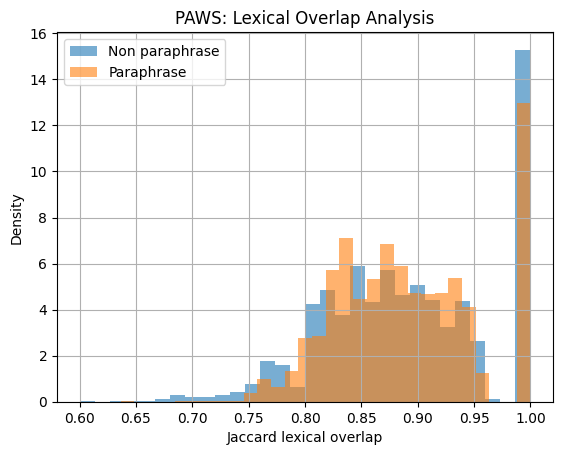

Average overlap score (label 0): 0.8905422585699789
Average overlap score (label 1): 0.8903039568751945


In [44]:
# 15. b)

word_regex = re.compile(r"[a-z]+")

def get_words(text):
    return set(word_regex.findall(text.lower()))

def jaccard_similarity(words1, words2):
    intersection = words1 & words2
    union = words1 | words2
    return len(intersection) / len(union) if union else 0.0

test_data = ds["test"]

overlap_non_para = []
overlap_para = []

for s1, s2, label in zip(
    test_data["sentence1"],
    test_data["sentence2"],
    test_data["label"]
):
    words1 = get_words(s1)
    words2 = get_words(s2)
    score = jaccard_similarity(words1, words2)

    if label == 0:
        overlap_non_para.append(score)
    else:
        overlap_para.append(score)

plt.figure()
plt.hist(overlap_non_para, bins=30, alpha=0.6, label="Non paraphrase", density=True)
plt.hist(overlap_para, bins=30, alpha=0.6, label="Paraphrase", density=True)
plt.xlabel("Jaccard lexical overlap")
plt.ylabel("Density")
plt.title("PAWS: Lexical Overlap Analysis")
plt.legend()
plt.grid(True)
plt.show()

print("Average overlap score (label 0):", np.mean(overlap_non_para))
print("Average overlap score (label 1):", np.mean(overlap_para))

Why might bag-of-words features struggle on this dataset?

    Bag-of-words models struggle because paraphrase and non-paraphrase pairs share very similar vocabularies and have high overlap. So it struggles to distinguish meaning.

In [45]:
# 15. c)

word_re = re.compile(r"[a-z]+")

def avg_glove(text, embeddings, dim=300):
    tokens = word_re.findall(text.lower())
    vectors = []

    for w in tokens:
        if w in embeddings:
            vectors.append(embeddings[w])

    if len(vectors) == 0:
        return np.zeros(dim)

    return np.mean(vectors, axis=0)

def build_pair_features(sents1, sents2, embeddings, dim=300):
    X = []

    for s1, s2 in zip(sents1, sents2):
        u = avg_glove(s1, embeddings, dim)
        v = avg_glove(s2, embeddings, dim)

        features = np.concatenate([
            u,
            v,
            np.abs(u - v),
            u * v
        ])
        X.append(features)

    return np.array(X)

train = ds["train"]
test = ds["test"]

X_train = build_pair_features(
    train["sentence1"],
    train["sentence2"],
    embeddings_dict
)
y_train = np.array(train["label"])

X_test = build_pair_features(
    test["sentence1"],
    test["sentence2"],
    embeddings_dict
)
y_test = np.array(test["label"])

clf = LogisticRegression(max_iter=3000, solver="liblinear")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", round(acc, 4))
print("F1:", round(f1, 4))
print("Confusion Matrix:\n", cm)

Accuracy: 0.562
F1: 0.3259
Confusion Matrix:
 [[3649  815]
 [2689  847]]


We average pretrained GLoVe embeddings to represent each sentence and build pair features [u,v,∣u−v∣,u⊙v]

In [ ]:
# 16. a)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")
model_encoder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=device)

print("Using device:", model_encoder.device)

GPU name: NVIDIA GeForce RTX 3060
Using device: cuda:0


In [ ]:
ds = load_dataset("paws", "labeled_final")

train = ds["train"]
val   = ds["validation"]
test  = ds["test"]

y_train = np.array(train["label"])
y_val   = np.array(val["label"])
y_test  = np.array(test["label"])

def encode(texts):
    return model_encoder.encode(texts,batch_size=64,convert_to_numpy=True,normalize_embeddings=True,show_progress_bar=True)

train_u = encode(train["sentence1"])
train_v = encode(train["sentence2"])

val_u = encode(val["sentence1"])
val_v = encode(val["sentence2"])

test_u = encode(test["sentence1"])
test_v = encode(test["sentence2"])

Batches:   0%|          | 0/772 [00:00<?, ?it/s]

Batches:   0%|          | 0/772 [00:00<?, ?it/s]

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:

# choice of constructing features): [u, v, |u − v|, u ⊙ v]
def construct_features(u, v):
    return np.concatenate([u, v, np.abs(u - v), u * v], axis=1)

X_train = construct_features(train_u, train_v)
X_val   = construct_features(val_u, val_v)
X_test  = construct_features(test_u, test_v)

C_list = [10**k for k in range(-5, 6)]

best_C = None
best_val_acc = -1

for C in C_list:
    model = LogisticRegression(C=C, max_iter=5000)
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_C = C

print("16. a)")
print("Tuned C:", best_C, "with accuracy:", round(best_val_acc, 4))

bi_clf = LogisticRegression(C=best_C, max_iter=5000)
bi_clf.fit(X_train, y_train)

bi_pred = bi_clf.predict(X_test)

bi_acc = accuracy_score(y_test, bi_pred)
bi_f1  = f1_score(y_test, bi_pred)
bi_cm  = confusion_matrix(y_test, bi_pred)

print("Test Accuracy:", bi_acc)
print("TestF1:", bi_f1)
print("Confusion matrix:\n", bi_cm)


16. a)
Tuned C: 1 with accuracy: 0.622
Test Accuracy: 0.61825
TestF1: 0.5269516728624535
Confusion matrix:
 [[3245 1219]
 [1835 1701]]


In [ ]:
# 16. b)

pretrained_encoder = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_batch(batch):
    return pretrained_encoder(batch["sentence1"], batch["sentence2"], truncation=True, padding="max_length", max_length=128)

train_tok = train.map(tokenize_batch, batched=True)
val_tok   = val.map(tokenize_batch, batched=True)
test_tok  = test.map(tokenize_batch, batched=True)

cols = ["input_ids", "attention_mask", "label"]
train_tok.set_format(type="torch", columns=cols)
val_tok.set_format(type="torch", columns=cols)
test_tok.set_format(type="torch", columns=cols)

acc_metric = evaluate.load("accuracy")
f1_metric  = evaluate.load("f1")

def metrics_fn(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": acc_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1_metric.compute(predictions=preds, references=labels)["f1"],
    }

lr_list = [5e-5, 2e-5]
best_lr = None
best_val_f1 = -1
best_trainer = None

for lr in lr_list:
    model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
    args = TrainingArguments(output_dir=f"./cross_lr_{lr}", learning_rate=lr, per_device_train_batch_size=16, per_device_eval_batch_size=32, num_train_epochs=1, eval_strategy="epoch", save_strategy="no", logging_steps=200, fp16=torch.cuda.is_available(), report_to="none")
    trainer = Trainer(model=model, args=args, train_dataset=train_tok, eval_dataset=val_tok, tokenizer=pretrained_encoder, compute_metrics=metrics_fn)

    trainer.train()
    val_metrics = trainer.evaluate()

    print("LR =", lr, "| Val F1 =", round(val_metrics["eval_f1"], 4))

    if val_metrics["eval_f1"] > best_val_f1:
        best_val_f1 = val_metrics["eval_f1"]
        best_lr = lr
        best_trainer = trainer

print("\nBest LR:", best_lr, "| Best Val F1:", round(best_val_f1, 4))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Joel\AppData\Local\Temp\ipykernel_23144\1657800986.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=args, train_dataset=train_tok, eval_dataset=val_tok, tokenizer=pretrained_encoder, compute_metrics=metrics_fn)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.308300,0.338549,0.866750,0.857410


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LR = 5e-05 | Val F1 = 0.8574


C:\Users\Joel\AppData\Local\Temp\ipykernel_23144\1657800986.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=args, train_dataset=train_tok, eval_dataset=val_tok, tokenizer=pretrained_encoder, compute_metrics=metrics_fn)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.428100,0.403580,0.826500,0.814488


LR = 2e-05 | Val F1 = 0.8145

Best LR: 5e-05 | Best Val F1: 0.8574


In [ ]:
test_logits = best_trainer.predict(test_tok).predictions
cross_pred = np.argmax(test_logits, axis=1)

cross_acc = accuracy_score(y_test, cross_pred)
cross_f1  = f1_score(y_test, cross_pred)
cross_cm  = confusion_matrix(y_test, cross_pred)

print("16. b) Cross-encoder fine-tuned (DistilBERT)")
print("Accuracy:", round(cross_acc, 4))
print("F1:", round(cross_f1, 4))
print("Confusion matrix:\n", cross_cm)

16. b) Cross-encoder fine-tuned (DistilBERT)
Accuracy: 0.8606
F1: 0.8498
Confusion matrix:
 [[3731  733]
 [ 382 3154]]


In [ ]:
def time_bi_encoder_1000():
    n = min(1000, len(test))
    s1 = test["sentence1"][:n]
    s2 = test["sentence2"][:n]

    temp = model_encoder.encode(s1, batch_size=64, convert_to_numpy=True, normalize_embeddings=True)
    temp = model_encoder.encode(s2, batch_size=64, convert_to_numpy=True, normalize_embeddings=True)

    t0 = time.time()
    temp = model_encoder.encode(s1, batch_size=64, convert_to_numpy=True, normalize_embeddings=True)
    temp = model_encoder.encode(s2, batch_size=64, convert_to_numpy=True, normalize_embeddings=True)
    return time.time() - t0

bi_time_1000 = time_bi_encoder_1000()
print("Approximate inference Bi-encoder time per 1000 pairs:", bi_time_1000, "sec")

def time_cross_encoder_1000():
    n = min(1000, len(test_tok))
    small = test_tok.select(range(n))

    temp = best_trainer.predict(small)

    t0 = time.time()
    temp = best_trainer.predict(small)
    return time.time() - t0

cross_time_1000 = time_cross_encoder_1000()
print("Approximate inference Cross-encoder time per 1000 pairs:", cross_time_1000, "sec")


Approximate inference Bi-encoder time per 1000 pairs: 0.6986372470855713 sec


Approximate inference Cross-encoder time per 1000 pairs: 1.0659687519073486 sec


16. c)

The result from part (b) is much better than from part (a) because the cross encoder aligns the words better between pairs using attention. It processes both sentences at the same time. Fine tuning also improves the result by overlapping non paraphrase pairs.


16. d) Model Comparison
Model                     | Test Acc | Test F1  | Time / 1000 pairs

Bi-encoder + LogReg       | 0.6182   | 0.5270   | 0.754 sec
Cross-encoder (fine-tune) | 0.8156   | 0.7989   | 1.130 sec
## Add glove from part 15. c) !!


In [ ]:
# 17. a)
dataset = load_dataset("paws", "labeled_final")
test_data = dataset["test"]

paraphrase_idx = [i for i, y in enumerate(test_data["label"]) if y == 1]
not_para_idx  = [i for i, y in enumerate(test_data["label"]) if y == 0]

rng = np.random.default_rng(42)

selected_idx = np.concatenate([
    rng.choice(paraphrase_idx, 100, replace=False),
    rng.choice(not_para_idx, 100, replace=False)
])

rng.shuffle(selected_idx)

test_subset = test_data.select(selected_idx.tolist())

print("Balanced subset size:", len(test_subset))

Balanced subset size: 200


In [ ]:
# 17. b)

def zero_shot_prompt(sentence1, sentence2):
    return (
        "Decide if the following two sentences have the same meaning.\n"
        "Answer with only ONE word: paraphrase or not_paraphrase.\n\n"
        f"Sentence 1: {sentence1}\n"
        f"Sentence 2: {sentence2}\n"
        "Answer:"
    )


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    dtype=torch.float16 if device == "cuda" else torch.float32,
    device_map="auto" if device == "cuda" else None
)

if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
label_re = re.compile(r"\b(paraphrase|not\s+paraphrase|not_paraphrase)\b", re.I)

def parse_label(text):
    m = label_re.search(text)
    if not m:
        return 0
    token = m.group(1).lower().replace("_", " ")
    return 1 if token == "paraphrase" else 0


@torch.no_grad()
def predict(s1, s2):
    prompt = zero_shot_prompt(s1, s2)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(model.device)

    outputs = model.generate( **inputs, max_new_tokens=6, do_sample=False, temperature=0.0, pad_token_id=tokenizer.eos_token_id)

    text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    if "Answer:" in text:
        text = text.split("Answer:")[-1]
    return parse_label(text)

y_true = test_subset["label"]
y_pred = [predict(s1, s2) for s1, s2 in zip(test_subset["sentence1"], test_subset["sentence2"])]

acc = accuracy_score(y_true, y_pred)
cm  = confusion_matrix(y_true, y_pred)

print("Zero-shot accuracy:", acc)
print("Confusion matrix:\n", cm)

Zero-shot accuracy: 0.835
Confusion matrix:
 [[86 14]
 [19 81]]


In [ ]:
# 17. c)
train_split = ds["train"]

train_para_idx = [i for i, y in enumerate(train_split["label"]) if y == 1]
train_not_idx  = [i for i, y in enumerate(train_split["label"]) if y == 0]

rng = np.random.default_rng(42)
shot_idx = np.concatenate([
    rng.choice(train_para_idx, 3, replace=False),
    rng.choice(train_not_idx,  3, replace=False)
])
rng.shuffle(shot_idx)
shots = train_split.select(shot_idx.tolist())

def few_shot_prompt(s1, s2, shots):
    ex_blocks = []
    for ex1, ex2, y in zip(shots["sentence1"], shots["sentence2"], shots["label"]):
        label = "paraphrase" if y == 1 else "not_paraphrase"
        ex_blocks.append(
            f"Sentence 1: {ex1}\nSentence 2: {ex2}\nAnswer: {label}\n"
        )

    examples_text = "\n".join(ex_blocks)

    return (
        "Decide if the following two sentences have the same meaning.\n"
        "Answer with only ONE word: paraphrase or not_paraphrase.\n\n"
        "Examples:\n"
        f"{examples_text}\n"
        "Now classify:\n"
        f"Sentence 1: {s1}\n"
        f"Sentence 2: {s2}\n"
        "Answer:"
    )

label_re = re.compile(r"\b(paraphrase|not\s+paraphrase|not_paraphrase)\b", re.I)

def parse_label(text):
    m = label_re.search(text)
    if not m:
        return 0
    t = m.group(1).lower().replace("_", " ")
    return 1 if t == "paraphrase" else 0

@torch.no_grad()
def predict_fewshot(s1, s2):
    prompt = few_shot_prompt(s1, s2, shots)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(model.device)

    outputs = model.generate(**inputs, max_new_tokens=6, do_sample=False, pad_token_id=tokenizer.eos_token_id)

    text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    if "Answer:" in text:
        text = text.split("Answer:")[-1]
    return parse_label(text)

In [ ]:
y_true = test_subset["label"]
y_pred_fs = [predict_fewshot(s1, s2) for s1, s2 in zip(test_subset["sentence1"], test_subset["sentence2"])]

acc_fs = accuracy_score(y_true, y_pred_fs)
cm_fs  = confusion_matrix(y_true, y_pred_fs)

print("Few-shot accuracy:", acc_fs)
print("Confusion matrix:\n", cm_fs)

print("Model name:", MODEL_NAME)
print("Decoding parameters: do_sample=False, max_new_tokens=6")
print(few_shot_prompt("SENTENCE1", "SENTENCE2", shots))

Few-shot accuracy: 0.825
Confusion matrix:
 [[82 18]
 [17 83]]
Model name: Qwen/Qwen3-4B-Instruct-2507
Decoding parameters: do_sample=False, max_new_tokens=6
Decide if the following two sentences have the same meaning.
Answer with only ONE word: paraphrase or not_paraphrase.

Examples:
Sentence 1: Little Tramp is a musical containing a book by David Pomeranz and music and texts by David Pomeranz and Steven David Horwich .
Sentence 2: Little Tramp is a musical with a book by David Pomeranz and music and lyrics by David Pomeranz and Steven David Horwich .
Answer: paraphrase

Sentence 1: It began as a fishing village , populated by Polish settlers from the Kaszub region and some German immigrants in 1870 .
Sentence 2: It began as a fishing village inhabited by German settlers from the region of Kaszub , as well as some Polish immigrants in 1870 .
Answer: not_paraphrase

Sentence 1: On June 30 , 2016 , Infante agreed to a minor league deal with the Atlanta Braves . He was released by the B

17. d)

Zero-shot accuracy: 0.835
Confusion matrix:
 [[86 14]
 [19 81]]

Few-shot accuracy: 0.825
Confusion matrix:
 [[82 18]
 [17 83]]

Accuracy: The best prompting result is zero-shot with accuracy = 0.835. This is good, but a little less reliable than the fine-tuned cross-encoder above. This is because cross-encoder is trained specifically for PAWS and generalizes better.

Runtime: Prompting is slower per sentence pair than cross-encoder since the cross-encoder performs a single forward pass.

Reproducibility: Prompting is sensitive to prompt wording and few-shot example selection, so cross-encoder is better for reproducibility because its predictions are fixed based on the training data.